In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive
drive.mount('/content/drive')
import json
import torchvision.ops
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from torchvision.ops import box_convert

import matplotlib.pyplot as plt
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
import sys

Mounted at /content/drive


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [ ]:
#Common Objects in Context
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class UI_Element_Detection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "annotations_train.json"))  # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    # to load annotations for a given image ID.
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        # print(f"Loading index: {index}")  # Basic logging
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # copies the annotations to avoid modifying the original data.
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        category_id_to_index = {cat_id: idx for idx, (cat_id, cat_info) in enumerate(categories.items())}

        targ = {}  # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([category_id_to_index[t['category_id']] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ  # scale images

    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/My Drive/MASC_UI_dataset/MASC_UI/MASC_UI/Login/"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "annotations_train.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=4.58s)
creating index...
index created!


{1: {'id': 1, 'name': 'Element'},
 2: {'id': 2, 'name': 'ImageView'},
 3: {'id': 3, 'name': 'TextView'},
 4: {'id': 4, 'name': 'Button'},
 5: {'id': 5, 'name': 'Input'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Element', 'ImageView', 'TextView', 'Button', 'Input']

In [ ]:
train_dataset = UI_Element_Detection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [ ]:
val_dataset = UI_Element_Detection(root=dataset_path, split="val", transforms=get_transforms(False))


loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


File Name: 42511.jpg
Bounding Box 0: tensor([   0.0000, 1081.8750, 1200.0000, 1160.6250]), Category ID: 0, Category Name: Element
Bounding Box 1: tensor([ 748.3333, 1005.9375,  806.6667, 1039.6875]), Category ID: 1, Category Name: ImageView
Bounding Box 2: tensor([ 393.3333, 1007.3438,  725.0000, 1038.2812]), Category ID: 2, Category Name: TextView
Bounding Box 3: tensor([  46.6667,  893.4375, 1153.3334,  950.6250]), Category ID: 2, Category Name: TextView
Bounding Box 4: tensor([  46.6667,  796.8750, 1153.3334,  854.0625]), Category ID: 4, Category Name: Input
Bounding Box 5: tensor([ 776.6667,  708.2812, 1153.3334,  783.7500]), Category ID: 0, Category Name: Element
Bounding Box 6: tensor([  46.6667,  642.6562, 1153.3334,  708.2812]), Category ID: 3, Category Name: Button
Bounding Box 7: tensor([ 46.6667, 559.2188, 354.1667, 616.4062]), Category ID: 2, Category Name: TextView
Bounding Box 8: tensor([  46.6667,  454.2188, 1153.3334,  519.8438]), Category ID: 3, Category Name: Button


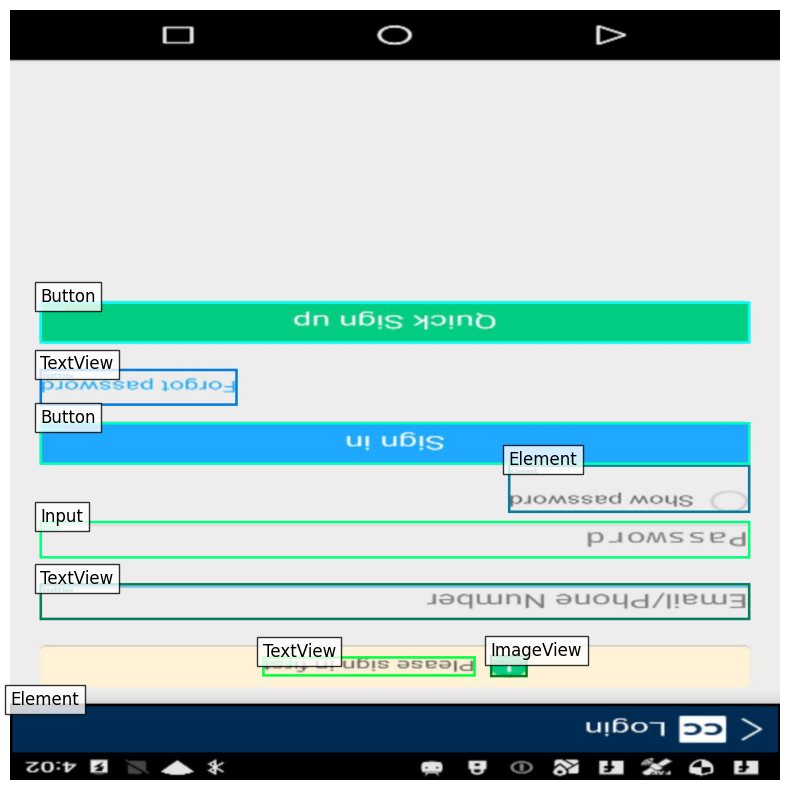

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Add method to get file name
def get_file_name(coco, image_id):
    return coco.loadImgs(image_id)[0]['file_name']

# Let's view a sample
sample_index = 333 # Sample index to view
sample = train_dataset[sample_index]
img_tensor = sample[0] * 255
img_int = img_tensor.to(torch.uint8)

# Get the file name
image_id = sample[1]['image_id'][0].item()  # Take the first image_id from the tensor
file_name = get_file_name(train_dataset.coco, image_id)

# Resize image for a larger display
# This will not increase the actual quality but will make the image larger on the screen
# Replace 'new_width' and 'new_height' with desired dimensions
new_width, new_height = img_tensor.shape[2] * 2, img_tensor.shape[1] * 2  # For example, doubling the size
img_resized = F.resize(img_int, [new_height, new_width])

# Convert boxes to the resized scale
boxes_resized = sample[1]['boxes'] * torch.tensor([2, 2, 2, 2], dtype=torch.float32)

# Draw bounding boxes on the resized image
img_with_boxes = draw_bounding_boxes(
    img_resized, boxes_resized, [classes[i] for i in sample[1]['labels']], width=4
)

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))  # You can adjust the display size by changing the figsize
plt.imshow(img_with_boxes.permute(1, 2, 0))

# Increase font size for bounding box labels
for i, label in enumerate(sample[1]['labels']):
    box = boxes_resized[i]
    category_id = label.item()
    category_name = classes[category_id]
    plt.text(box[0], box[1], f"{category_name}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.axis('off')  # Hide the axes

# Print the file name
print(f"File Name: {file_name}")

# Print the category_id for each bounding box
for i, label in enumerate(sample[1]['labels']):
    box = boxes_resized[i]
    category_id = label.item()
    print(f"Bounding Box {i}: {box}, Category ID: {category_id}, Category Name: {classes[category_id]}")

plt.show()

In [ ]:
# MobileNet V3 is a type of convolutional neural network used to extract features from the input image
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# ROI (Region of Interest) is used to ensure compatibility when customizing the model's prediction head for a specific number of classes.
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 96.5MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# DataLoader class provided by PyTorch that provides an iterable over the data.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
# passes the list of images and targets to the model to ensure it runs without errors.
output = model(images, targets)

In [ ]:
device = torch.device("cuda") # use GPU to train

In [ ]:
model = model.to(device)

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.007, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

In [ ]:

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

    return all_losses, all_losses_dict


In [ ]:
import torch
import time
import numpy as np
from pycocotools.coco import COCO
import os


num_epochs = 50

# Start the timer for total training time
total_start_time = time.time()

for epoch in range(num_epochs):
    # Start the timer for the epoch
    epoch_start_time = time.time()

    train_one_epoch(model, optimizer, train_loader, device, epoch)


# End the timer for total training time
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Total training time: {total_duration:.2f} seconds")

100%|██████████| 78/78 [01:03<00:00,  1.23it/s]


Epoch 0, lr: 0.007000, loss: 1.248515, loss_classifier: 0.389679, loss_box: 0.379714, loss_rpn_box: 0.258017, loss_object: 0.221106


100%|██████████| 78/78 [00:34<00:00,  2.27it/s]


Epoch 1, lr: 0.007000, loss: 0.892377, loss_classifier: 0.285682, loss_box: 0.287348, loss_rpn_box: 0.190224, loss_object: 0.129124


100%|██████████| 78/78 [00:35<00:00,  2.20it/s]


Epoch 2, lr: 0.007000, loss: 0.823428, loss_classifier: 0.262839, loss_box: 0.260354, loss_rpn_box: 0.178632, loss_object: 0.121603


100%|██████████| 78/78 [00:34<00:00,  2.29it/s]


Epoch 3, lr: 0.007000, loss: 0.784978, loss_classifier: 0.250218, loss_box: 0.243490, loss_rpn_box: 0.172172, loss_object: 0.119097


100%|██████████| 78/78 [00:31<00:00,  2.47it/s]


Epoch 4, lr: 0.007000, loss: 0.758795, loss_classifier: 0.243817, loss_box: 0.234480, loss_rpn_box: 0.164492, loss_object: 0.116006


100%|██████████| 78/78 [00:31<00:00,  2.45it/s]


Epoch 5, lr: 0.007000, loss: 0.727012, loss_classifier: 0.237264, loss_box: 0.223018, loss_rpn_box: 0.159384, loss_object: 0.107347


100%|██████████| 78/78 [00:31<00:00,  2.45it/s]


Epoch 6, lr: 0.007000, loss: 0.717396, loss_classifier: 0.230474, loss_box: 0.220777, loss_rpn_box: 0.157774, loss_object: 0.108370


100%|██████████| 78/78 [00:35<00:00,  2.22it/s]


Epoch 7, lr: 0.007000, loss: 0.691301, loss_classifier: 0.220798, loss_box: 0.213424, loss_rpn_box: 0.151450, loss_object: 0.105630


100%|██████████| 78/78 [00:35<00:00,  2.23it/s]


Epoch 8, lr: 0.007000, loss: 0.680327, loss_classifier: 0.220266, loss_box: 0.207123, loss_rpn_box: 0.150468, loss_object: 0.102470


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


Epoch 9, lr: 0.007000, loss: 0.668853, loss_classifier: 0.217496, loss_box: 0.206094, loss_rpn_box: 0.147994, loss_object: 0.097269


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]


Epoch 10, lr: 0.007000, loss: 0.656027, loss_classifier: 0.211196, loss_box: 0.202196, loss_rpn_box: 0.145544, loss_object: 0.097090


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]


Epoch 11, lr: 0.007000, loss: 0.651475, loss_classifier: 0.209885, loss_box: 0.202391, loss_rpn_box: 0.142990, loss_object: 0.096209


100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 12, lr: 0.007000, loss: 0.631627, loss_classifier: 0.203251, loss_box: 0.196592, loss_rpn_box: 0.140388, loss_object: 0.091394


100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 13, lr: 0.007000, loss: 0.627838, loss_classifier: 0.202877, loss_box: 0.194430, loss_rpn_box: 0.139453, loss_object: 0.091078


100%|██████████| 78/78 [00:32<00:00,  2.38it/s]


Epoch 14, lr: 0.007000, loss: 0.615550, loss_classifier: 0.195393, loss_box: 0.192067, loss_rpn_box: 0.138450, loss_object: 0.089640


100%|██████████| 78/78 [00:31<00:00,  2.47it/s]


Epoch 15, lr: 0.007000, loss: 0.601631, loss_classifier: 0.190621, loss_box: 0.187665, loss_rpn_box: 0.135331, loss_object: 0.088014


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]


Epoch 16, lr: 0.007000, loss: 0.590185, loss_classifier: 0.187028, loss_box: 0.186813, loss_rpn_box: 0.132644, loss_object: 0.083700


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


Epoch 17, lr: 0.007000, loss: 0.584342, loss_classifier: 0.184913, loss_box: 0.183450, loss_rpn_box: 0.132606, loss_object: 0.083373


100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 18, lr: 0.007000, loss: 0.573520, loss_classifier: 0.179438, loss_box: 0.184196, loss_rpn_box: 0.129578, loss_object: 0.080309


100%|██████████| 78/78 [00:32<00:00,  2.42it/s]


Epoch 19, lr: 0.007000, loss: 0.571732, loss_classifier: 0.179055, loss_box: 0.184327, loss_rpn_box: 0.128701, loss_object: 0.079648


100%|██████████| 78/78 [00:31<00:00,  2.47it/s]


Epoch 20, lr: 0.007000, loss: 0.557600, loss_classifier: 0.171467, loss_box: 0.178783, loss_rpn_box: 0.128273, loss_object: 0.079077


100%|██████████| 78/78 [00:32<00:00,  2.40it/s]


Epoch 21, lr: 0.007000, loss: 0.547092, loss_classifier: 0.166402, loss_box: 0.176531, loss_rpn_box: 0.126852, loss_object: 0.077306


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


Epoch 22, lr: 0.007000, loss: 0.544735, loss_classifier: 0.165626, loss_box: 0.177517, loss_rpn_box: 0.124557, loss_object: 0.077034


100%|██████████| 78/78 [00:35<00:00,  2.22it/s]


Epoch 23, lr: 0.007000, loss: 0.538598, loss_classifier: 0.163215, loss_box: 0.175709, loss_rpn_box: 0.124027, loss_object: 0.075646


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]


Epoch 24, lr: 0.007000, loss: 0.526209, loss_classifier: 0.159142, loss_box: 0.173553, loss_rpn_box: 0.122178, loss_object: 0.071336


100%|██████████| 78/78 [00:31<00:00,  2.51it/s]


Epoch 25, lr: 0.007000, loss: 0.517068, loss_classifier: 0.154878, loss_box: 0.172936, loss_rpn_box: 0.118989, loss_object: 0.070266


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]


Epoch 26, lr: 0.007000, loss: 0.509559, loss_classifier: 0.153271, loss_box: 0.168220, loss_rpn_box: 0.117659, loss_object: 0.070408


100%|██████████| 78/78 [00:34<00:00,  2.24it/s]


Epoch 27, lr: 0.007000, loss: 0.504079, loss_classifier: 0.149426, loss_box: 0.170240, loss_rpn_box: 0.115422, loss_object: 0.068991


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


Epoch 28, lr: 0.007000, loss: 0.503469, loss_classifier: 0.150512, loss_box: 0.170658, loss_rpn_box: 0.115472, loss_object: 0.066826


100%|██████████| 78/78 [00:31<00:00,  2.51it/s]


Epoch 29, lr: 0.007000, loss: 0.502232, loss_classifier: 0.149921, loss_box: 0.168821, loss_rpn_box: 0.114427, loss_object: 0.069063


100%|██████████| 78/78 [00:30<00:00,  2.53it/s]


Epoch 30, lr: 0.007000, loss: 0.490666, loss_classifier: 0.144775, loss_box: 0.167223, loss_rpn_box: 0.113010, loss_object: 0.065659


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


Epoch 31, lr: 0.007000, loss: 0.480617, loss_classifier: 0.138170, loss_box: 0.166726, loss_rpn_box: 0.110499, loss_object: 0.065222


100%|██████████| 78/78 [00:34<00:00,  2.28it/s]


Epoch 32, lr: 0.007000, loss: 0.484767, loss_classifier: 0.141206, loss_box: 0.166246, loss_rpn_box: 0.112385, loss_object: 0.064930


100%|██████████| 78/78 [00:33<00:00,  2.32it/s]


Epoch 33, lr: 0.007000, loss: 0.470379, loss_classifier: 0.134625, loss_box: 0.162873, loss_rpn_box: 0.108169, loss_object: 0.064711


100%|██████████| 78/78 [00:31<00:00,  2.51it/s]


Epoch 34, lr: 0.007000, loss: 0.461165, loss_classifier: 0.130582, loss_box: 0.162355, loss_rpn_box: 0.107794, loss_object: 0.060435


100%|██████████| 78/78 [00:32<00:00,  2.37it/s]


Epoch 35, lr: 0.007000, loss: 0.462885, loss_classifier: 0.130892, loss_box: 0.162830, loss_rpn_box: 0.106637, loss_object: 0.062526


100%|██████████| 78/78 [00:33<00:00,  2.35it/s]


Epoch 36, lr: 0.007000, loss: 0.455547, loss_classifier: 0.126958, loss_box: 0.162062, loss_rpn_box: 0.106180, loss_object: 0.060346


100%|██████████| 78/78 [00:32<00:00,  2.41it/s]


Epoch 37, lr: 0.007000, loss: 0.456227, loss_classifier: 0.130892, loss_box: 0.161495, loss_rpn_box: 0.104274, loss_object: 0.059565


100%|██████████| 78/78 [00:31<00:00,  2.48it/s]


Epoch 38, lr: 0.007000, loss: 0.449741, loss_classifier: 0.127902, loss_box: 0.158871, loss_rpn_box: 0.105597, loss_object: 0.057370


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


Epoch 39, lr: 0.007000, loss: 0.442273, loss_classifier: 0.123034, loss_box: 0.159912, loss_rpn_box: 0.103638, loss_object: 0.055688


100%|██████████| 78/78 [00:33<00:00,  2.36it/s]


Epoch 40, lr: 0.007000, loss: 0.440391, loss_classifier: 0.122110, loss_box: 0.159630, loss_rpn_box: 0.102711, loss_object: 0.055940


100%|██████████| 78/78 [00:31<00:00,  2.48it/s]


Epoch 41, lr: 0.007000, loss: 0.437562, loss_classifier: 0.121513, loss_box: 0.159275, loss_rpn_box: 0.100270, loss_object: 0.056504


100%|██████████| 78/78 [00:30<00:00,  2.55it/s]


Epoch 42, lr: 0.007000, loss: 0.432876, loss_classifier: 0.120214, loss_box: 0.157719, loss_rpn_box: 0.099853, loss_object: 0.055089


100%|██████████| 78/78 [00:33<00:00,  2.30it/s]


Epoch 43, lr: 0.007000, loss: 0.422164, loss_classifier: 0.115819, loss_box: 0.155054, loss_rpn_box: 0.098620, loss_object: 0.052671


100%|██████████| 78/78 [00:34<00:00,  2.23it/s]


Epoch 44, lr: 0.007000, loss: 0.423014, loss_classifier: 0.116709, loss_box: 0.155887, loss_rpn_box: 0.096895, loss_object: 0.053523


100%|██████████| 78/78 [00:30<00:00,  2.55it/s]


Epoch 45, lr: 0.007000, loss: 0.429291, loss_classifier: 0.119168, loss_box: 0.158208, loss_rpn_box: 0.098571, loss_object: 0.053344


100%|██████████| 78/78 [00:30<00:00,  2.56it/s]


Epoch 46, lr: 0.007000, loss: 0.422973, loss_classifier: 0.118193, loss_box: 0.156292, loss_rpn_box: 0.095388, loss_object: 0.053100


100%|██████████| 78/78 [00:32<00:00,  2.38it/s]


Epoch 47, lr: 0.007000, loss: 0.414838, loss_classifier: 0.112423, loss_box: 0.153103, loss_rpn_box: 0.096387, loss_object: 0.052925


100%|██████████| 78/78 [00:34<00:00,  2.26it/s]


Epoch 48, lr: 0.007000, loss: 0.410910, loss_classifier: 0.112388, loss_box: 0.153910, loss_rpn_box: 0.095182, loss_object: 0.049430


100%|██████████| 78/78 [00:32<00:00,  2.42it/s]

Epoch 49, lr: 0.007000, loss: 0.408573, loss_classifier: 0.110124, loss_box: 0.154298, loss_rpn_box: 0.094536, loss_object: 0.049615
Total training time: 1683.23 seconds


In [ ]:
# # Convert epoch_losses_dict to a DataFrame for easier plotting
# epoch_losses_df = pd.DataFrame(epoch_losses_dict)

# # Plot the overall loss
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_epochs), epoch_losses, label='Total Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.legend()
# plt.show()

# # Plot the individual components of the loss
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_epochs), epoch_losses_df['loss_classifier'], label='Loss Classifier')
# plt.plot(range(num_epochs), epoch_losses_df['loss_box_reg'], label='Loss Box Reg')
# plt.plot(range(num_epochs), epoch_losses_df['loss_rpn_box_reg'], label='Loss RPN Box Reg')
# plt.plot(range(num_epochs), epoch_losses_df['loss_objectness'], label='Loss Objectness')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Individual Loss Components Over Epochs')
# plt.legend()
# plt.show()


In [ ]:
# def check_class_distribution(loader):
#     class_counts = [0] * 5  # Assuming classes are labeled from 1 to 5

#     for _, targets in loader:
#         for target in targets:
#             labels = target['labels'].numpy()
#             for label in labels:
#                 class_counts[label] += 1

#     return class_counts

# train_class_distribution = check_class_distribution(train_loader)
# val_class_distribution = check_class_distribution(val_loader)

# print(f"Train class distribution: {train_class_distribution}")
# print(f"Validation class distribution: {val_class_distribution}")

Train class distribution: [827, 778, 1862, 943, 1077]
Validation class distribution: [156, 222, 432, 205, 223]


CUDA is available. Using GPU.


100%|██████████| 78/78 [00:53<00:00,  1.45it/s]

Epoch 0, lr: 0.007000, loss: 1.250037, loss_classifier: 0.391150, loss_box: 0.381821, loss_rpn_box: 0.259727, loss_object: 0.217339


Epoch 0 - Train mAP@0.50: 0.5632046431331257
Element - Precision: 0.5102937234563225, Recall: 0.14469502220144892, AP: 0.15360895307117114
ImageView - Precision: 0.9577983299620669, Recall: 0.20603791345823902, AP: 0.37690885334261204
TextView - Precision: 0.9127668565580603, Recall: 0.5107667284316352, AP: 0.7782953010961717
Button - Precision: 0.9185354528079297, Recall: 0.6361821132963335, AP: 0.9440054650225478
Epoch 0 - Validation mAP@0.50: 0.48706635737249787
Element - Precision: 0.4416303010982701, Recall: 0.11528194861528196, AP: 0.11667882180951039
ImageView - Precision: 0.8044251757785099, Recall: 0.1601123595505618, AP: 0.24138118999260183
TextView - Precision: 0.8718970848328501, Recall: 0.4786885245901639, AP: 0.6973078043484
Button - Precision: 0.8760366850260747, Recall: 0.6342416925376566, AP: 0.8928976133394793
Epoch 0 completed in 146.57 seconds


100%|██████████| 78/78 [00:35<00:00,  2.21it/s]

Epoch 1, lr: 0.007000, loss: 0.898258, loss_classifier: 0.285946, loss_box: 0.285534, loss_rpn_box: 0.195052, loss_object: 0.131725


Epoch 1 - Train mAP@0.50: 0.6767248213471044
Element - Precision: 0.7729035738392658, Recall: 0.3019509103074268, AP: 0.42134275585161934
ImageView - Precision: 0.9080061435415071, Recall: 0.3286704543981875, AP: 0.5370114914420554
TextView - Precision: 0.9448731453660092, Recall: 0.49263959680270014, AP: 0.8043360753420541
Button - Precision: 0.9617662275222296, Recall: 0.5831742742736532, AP: 0.9442089627526886
Epoch 1 - Validation mAP@0.50: 0.5834132076534108
Element - Precision: 0.775402056069879, Recall: 0.27644118106545845, AP: 0.38678872028168004
ImageView - Precision: 0.7887732373315135, Recall: 0.23805099113197709, AP: 0.3372712542904406
TextView - Precision: 0.8874968678080504, Recall: 0.4555835065077107, AP: 0.7046805320060479
Button - Precision: 0.9398594128213075, Recall: 0.5726441553502669, AP: 0.9049123240354745
Epoch 1 completed in 138.71 seconds


100%|██████████| 78/78 [00:33<00:00,  2.35it/s]

Epoch 2, lr: 0.007000, loss: 0.820168, loss_classifier: 0.262320, loss_box: 0.255439, loss_rpn_box: 0.179757, loss_object: 0.122653


Epoch 2 - Train mAP@0.50: 0.7525733506518046
Element - Precision: 0.81075863784406, Recall: 0.3753477706332895, AP: 0.5389660075920847
ImageView - Precision: 0.8149066943752598, Recall: 0.4774773415238213, AP: 0.6582595181531314
TextView - Precision: 0.95646617223005, Recall: 0.5132352328150402, AP: 0.8532770505952498
Button - Precision: 0.8606160747526307, Recall: 0.7034504463128298, AP: 0.9597908262667528
Epoch 2 - Validation mAP@0.50: 0.6280576988650255
Element - Precision: 0.7643869420078306, Recall: 0.30607994929602966, AP: 0.40484342816811514
ImageView - Precision: 0.7059071284348443, Recall: 0.3605702236890356, AP: 0.44664511424990355
TextView - Precision: 0.873334539845526, Recall: 0.5017005150131182, AP: 0.7376548893939789
Button - Precision: 0.8328527319896016, Recall: 0.6962255329096977, AP: 0.9230873636481042
Epoch 2 completed in 161.36 seconds


100%|██████████| 78/78 [00:34<00:00,  2.25it/s]

Epoch 3, lr: 0.007000, loss: 0.778059, loss_classifier: 0.248593, loss_box: 0.241282, loss_rpn_box: 0.170141, loss_object: 0.118043


Epoch 3 - Train mAP@0.50: 0.7345285104300721
Element - Precision: 0.7799048458544905, Recall: 0.4369970949066817, AP: 0.5862721486382115
ImageView - Precision: 0.9217553471826574, Recall: 0.33903766040943134, AP: 0.5697447769135717
TextView - Precision: 0.9484256723325144, Recall: 0.5131043612443761, AP: 0.8488246100297792
Button - Precision: 0.975607461218142, Recall: 0.5497207734642542, AP: 0.9332725061387256
Epoch 3 - Validation mAP@0.50: 0.6281125726222005
Element - Precision: 0.7315466136942598, Recall: 0.3556225548257421, AP: 0.4510200177179374
ImageView - Precision: 0.8306946167165211, Recall: 0.2718841374269006, AP: 0.40830249148103076
TextView - Precision: 0.890431146033826, Recall: 0.503386985286857, AP: 0.7615747937458552
Button - Precision: 0.953456830424138, Recall: 0.5481723060198397, AP: 0.8915529875439789
Epoch 3 completed in 136.65 seconds


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]

Epoch 4, lr: 0.007000, loss: 0.749705, loss_classifier: 0.239275, loss_box: 0.230005, loss_rpn_box: 0.165557, loss_object: 0.114868


Epoch 4 - Train mAP@0.50: 0.759161184359572
Element - Precision: 0.7742081172537574, Recall: 0.4730341892685556, AP: 0.6220919873570234
ImageView - Precision: 0.846127561441344, Recall: 0.4106540840324452, AP: 0.6140583000713198
TextView - Precision: 0.9593360046296374, Recall: 0.5021464877317439, AP: 0.8452370934277458
Button - Precision: 0.9158190441802813, Recall: 0.6489225353316131, AP: 0.9552573565821987
Epoch 4 - Validation mAP@0.50: 0.633309357675283
Element - Precision: 0.7325185220118297, Recall: 0.3891925633498667, AP: 0.5002208297248213
ImageView - Precision: 0.7242931916884987, Recall: 0.3156301987566763, AP: 0.41361997360737446
TextView - Precision: 0.8826099748092107, Recall: 0.47867685543808225, AP: 0.7312042680638441
Button - Precision: 0.9009819727948374, Recall: 0.6085743242305182, AP: 0.888192359305092
Epoch 4 completed in 158.81 seconds


100%|██████████| 78/78 [00:33<00:00,  2.35it/s]

Epoch 5, lr: 0.007000, loss: 0.737323, loss_classifier: 0.237710, loss_box: 0.227092, loss_rpn_box: 0.161951, loss_object: 0.110571


Epoch 5 - Train mAP@0.50: 0.7328117805490697
Element - Precision: 0.8469056824178806, Recall: 0.3824750165988525, AP: 0.5591360037702047
ImageView - Precision: 0.910907486502433, Recall: 0.3794802027884734, AP: 0.6167178371659952
TextView - Precision: 0.9582864925243367, Recall: 0.4829841798861645, AP: 0.8194441974544205
Button - Precision: 0.9718146203607723, Recall: 0.5600501538978937, AP: 0.9359490838056584
Epoch 5 - Validation mAP@0.50: 0.6341937068684633
Element - Precision: 0.8363015758246909, Recall: 0.32941842365926133, AP: 0.4796561089334416
ImageView - Precision: 0.8126951259075414, Recall: 0.30841810119979135, AP: 0.45204652429209286
TextView - Precision: 0.9234712441699556, Recall: 0.4596307271483929, AP: 0.7347937032612347
Button - Precision: 0.960186769458431, Recall: 0.5228267329407315, AP: 0.870278490987084
Epoch 5 completed in 138.75 seconds


100%|██████████| 78/78 [00:33<00:00,  2.36it/s]

Epoch 6, lr: 0.007000, loss: 0.711476, loss_classifier: 0.230722, loss_box: 0.218585, loss_rpn_box: 0.154775, loss_object: 0.107394


Epoch 6 - Train mAP@0.50: 0.7675972443212193
Element - Precision: 0.8441475279976629, Recall: 0.3983402895207562, AP: 0.5886372424230222
ImageView - Precision: 0.8568354874718163, Recall: 0.46713611588332454, AP: 0.6877506469185336
TextView - Precision: 0.9504678149636419, Recall: 0.5225144886433698, AP: 0.8559976825434872
Button - Precision: 0.9817650706126217, Recall: 0.5391248839368616, AP: 0.938003405399835
Epoch 6 - Validation mAP@0.50: 0.6498989549266719
Element - Precision: 0.8022553891288604, Recall: 0.35337206365243745, AP: 0.5008020488682288
ImageView - Precision: 0.7397600292017418, Recall: 0.35910818713450293, AP: 0.46646451380551146
TextView - Precision: 0.9006580638364938, Recall: 0.49132448286508174, AP: 0.7527350851657293
Button - Precision: 0.9584444331174322, Recall: 0.5403674013539485, AP: 0.8795941718672182
Epoch 6 completed in 153.62 seconds


100%|██████████| 78/78 [00:34<00:00,  2.25it/s]

Epoch 7, lr: 0.007000, loss: 0.696128, loss_classifier: 0.222790, loss_box: 0.213513, loss_rpn_box: 0.155159, loss_object: 0.104666


Epoch 7 - Train mAP@0.50: 0.7151966014713101
Element - Precision: 0.8649697159090757, Recall: 0.35268463533188893, AP: 0.5340512337039918
ImageView - Precision: 0.9118042378559703, Recall: 0.3187035706579599, AP: 0.529662881513886
TextView - Precision: 0.9621730493144965, Recall: 0.501287233707464, AP: 0.8522829296179166
Button - Precision: 0.9836990054036906, Recall: 0.5379539109678012, AP: 0.9447893610494462
Epoch 7 - Validation mAP@0.50: 0.6241367530455807
Element - Precision: 0.8256214757020962, Recall: 0.3114228358793576, AP: 0.4541741033343073
ImageView - Precision: 0.7841002675536791, Recall: 0.26730019493177387, AP: 0.3762986373714925
TextView - Precision: 0.918450741222939, Recall: 0.4754559437486267, AP: 0.7641377240018934
Button - Precision: 0.9621045171143839, Recall: 0.5382742432735426, AP: 0.9019365474746298
Epoch 7 completed in 135.87 seconds


100%|██████████| 78/78 [00:35<00:00,  2.19it/s]

Epoch 8, lr: 0.007000, loss: 0.686582, loss_classifier: 0.222245, loss_box: 0.208833, loss_rpn_box: 0.152059, loss_object: 0.103446


Epoch 8 - Train mAP@0.50: 0.7724569976540866
Element - Precision: 0.8581551431072705, Recall: 0.45348385948428543, AP: 0.6666466755190534
ImageView - Precision: 0.9253597939895596, Recall: 0.3818256578947368, AP: 0.6369123662895838
TextView - Precision: 0.9690203801205906, Recall: 0.48163591965410446, AP: 0.8431724888397586
Button - Precision: 0.976374435879699, Recall: 0.5511679873657251, AP: 0.9430964599679507
Epoch 8 - Validation mAP@0.50: 0.6614062059272148
Element - Precision: 0.7928263086929729, Recall: 0.37885962885962887, AP: 0.5345929110895453
ImageView - Precision: 0.8236239201190433, Recall: 0.31702646239554316, AP: 0.47226406062853377
TextView - Precision: 0.9067744210468559, Recall: 0.4708301432790113, AP: 0.7491218928387374
Button - Precision: 0.9605257331249711, Recall: 0.5341285737074389, AP: 0.8896459591520423
Epoch 8 completed in 140.61 seconds


100%|██████████| 78/78 [00:33<00:00,  2.32it/s]

Epoch 9, lr: 0.007000, loss: 0.674159, loss_classifier: 0.215789, loss_box: 0.207669, loss_rpn_box: 0.149021, loss_object: 0.101681


Epoch 9 - Train mAP@0.50: 0.7643153991240115
Element - Precision: 0.8778787271101234, Recall: 0.4231891537482797, AP: 0.6553374813989515
ImageView - Precision: 0.8602832100934068, Recall: 0.3852554555656849, AP: 0.5886209816199208
TextView - Precision: 0.9770788149988024, Recall: 0.47999860260119026, AP: 0.8498991051087263
Button - Precision: 0.9687294895619001, Recall: 0.5800120473713325, AP: 0.9634040283684475
Epoch 9 - Validation mAP@0.50: 0.6477155367953337
Element - Precision: 0.8193291474472986, Recall: 0.36813324952859844, AP: 0.5199019329006105
ImageView - Precision: 0.7366062278229886, Recall: 0.3288235294117647, AP: 0.42682695647438706
TextView - Precision: 0.9154317280677914, Recall: 0.45284552845528453, AP: 0.7349242786181067
Button - Precision: 0.9501847145010808, Recall: 0.5638276979476939, AP: 0.9092089791882305
Epoch 9 completed in 143.38 seconds


100%|██████████| 78/78 [00:33<00:00,  2.33it/s]

Epoch 10, lr: 0.007000, loss: 0.664100, loss_classifier: 0.214102, loss_box: 0.203450, loss_rpn_box: 0.147094, loss_object: 0.099454


Epoch 10 - Train mAP@0.50: 0.7978624223171518
Element - Precision: 0.83438346133444, Recall: 0.47312662672559846, AP: 0.6727212515000696
ImageView - Precision: 0.872381334969144, Recall: 0.4290788925666937, AP: 0.6558760206463483
TextView - Precision: 0.9487059469727309, Recall: 0.5592273079017511, AP: 0.9087691111271232
Button - Precision: 0.9684728591467323, Recall: 0.5756187146462665, AP: 0.9540833059950657
Epoch 10 - Validation mAP@0.50: 0.6644181104165283
Element - Precision: 0.7735023369804631, Recall: 0.40690690690690684, AP: 0.54442085422607
ImageView - Precision: 0.7526248817735106, Recall: 0.3485621037704371, AP: 0.4634122298739238
TextView - Precision: 0.8554770727085705, Recall: 0.5116234756097562, AP: 0.7466029272846342
Button - Precision: 0.9476258114285379, Recall: 0.5690066780656193, AP: 0.9032364302814855
Epoch 10 completed in 152.42 seconds


100%|██████████| 78/78 [00:32<00:00,  2.37it/s]

Epoch 11, lr: 0.007000, loss: 0.644510, loss_classifier: 0.206640, loss_box: 0.199719, loss_rpn_box: 0.143635, loss_object: 0.094515


Epoch 11 - Train mAP@0.50: 0.769217419695046
Element - Precision: 0.8862492181568098, Recall: 0.43398362956771336, AP: 0.6650038881521297
ImageView - Precision: 0.9329114257564846, Recall: 0.3146210231720618, AP: 0.5459358046555998
TextView - Precision: 0.9329009344643491, Recall: 0.5804912534809336, AP: 0.9053530273937659
Button - Precision: 0.964242145332643, Recall: 0.5882121057287117, AP: 0.9605769585786886
Epoch 11 - Validation mAP@0.50: 0.6372615954610537
Element - Precision: 0.8162301108200513, Recall: 0.3800650871135453, AP: 0.5287566351833668
ImageView - Precision: 0.7929367227775006, Recall: 0.23563627730294398, AP: 0.35220734419804456
TextView - Precision: 0.8489596595883913, Recall: 0.5441446116588825, AP: 0.769733412605565
Button - Precision: 0.9505912525490513, Recall: 0.5601424426272752, AP: 0.8983489898572385
Epoch 11 completed in 133.04 seconds


100%|██████████| 78/78 [00:38<00:00,  2.00it/s]

Epoch 12, lr: 0.007000, loss: 0.638344, loss_classifier: 0.204423, loss_box: 0.198258, loss_rpn_box: 0.142563, loss_object: 0.093100


Epoch 12 - Train mAP@0.50: 0.8169907303413689
Element - Precision: 0.8995274645991067, Recall: 0.4422259484783456, AP: 0.6839904524210828
ImageView - Precision: 0.8859147914976985, Recall: 0.46138438569989143, AP: 0.7087273525014044
TextView - Precision: 0.9587000042720908, Recall: 0.5494613852926143, AP: 0.9093594772873196
Button - Precision: 0.9539559005411397, Recall: 0.6066529579846538, AP: 0.9658856391556689
Epoch 12 - Validation mAP@0.50: 0.6812186245684829
Element - Precision: 0.8386701643850416, Recall: 0.3928797218270903, AP: 0.5471671096230212
ImageView - Precision: 0.7724076613514099, Recall: 0.3773297170561119, AP: 0.5114065876566007
TextView - Precision: 0.8611060722770072, Recall: 0.4983374813339969, AP: 0.7389892789663058
Button - Precision: 0.9364958601549167, Recall: 0.5977367803292503, AP: 0.9273115220280039
Epoch 12 completed in 159.37 seconds


100%|██████████| 78/78 [00:33<00:00,  2.31it/s]

Epoch 13, lr: 0.007000, loss: 0.628075, loss_classifier: 0.203283, loss_box: 0.192183, loss_rpn_box: 0.141727, loss_object: 0.090882


Epoch 13 - Train mAP@0.50: 0.8146274204342914
Element - Precision: 0.8971673848198444, Recall: 0.4342528920308483, AP: 0.6765701850747039
ImageView - Precision: 0.8535326614815103, Recall: 0.48539870577775096, AP: 0.7197115827951748
TextView - Precision: 0.968822012850137, Recall: 0.5218340499930086, AP: 0.891289228107577
Button - Precision: 0.938996960736777, Recall: 0.6340526201634267, AP: 0.9709386857597095
Epoch 13 - Validation mAP@0.50: 0.6689855959652024
Element - Precision: 0.8037243999501553, Recall: 0.359839005672339, AP: 0.5076316012429537
ImageView - Precision: 0.7428250060636793, Recall: 0.37565658308411937, AP: 0.49140438839109185
TextView - Precision: 0.899210716566518, Recall: 0.48571428571428554, AP: 0.7610987771300286
Button - Precision: 0.915767970053179, Recall: 0.6139690329131061, AP: 0.9158076170967354
Epoch 13 completed in 158.88 seconds


100%|██████████| 78/78 [00:33<00:00,  2.33it/s]

Epoch 14, lr: 0.007000, loss: 0.618402, loss_classifier: 0.194778, loss_box: 0.193119, loss_rpn_box: 0.138665, loss_object: 0.091839


Epoch 14 - Train mAP@0.50: 0.8163644922900419
Element - Precision: 0.9387627530861191, Recall: 0.38853152492952886, AP: 0.6579806411572309
ImageView - Precision: 0.8930527727561048, Recall: 0.49519829511951047, AP: 0.7566618090190829
TextView - Precision: 0.9830381958599068, Recall: 0.4948638469780617, AP: 0.8879906941994613
Button - Precision: 0.9703404847339299, Recall: 0.5794824360135804, AP: 0.9628248247843927
Epoch 14 - Validation mAP@0.50: 0.666998507391338
Element - Precision: 0.8456722107254155, Recall: 0.352362566648281, AP: 0.5263979082692892
ImageView - Precision: 0.764496574171705, Recall: 0.39818525940770433, AP: 0.5236133763906563
TextView - Precision: 0.9029393355318596, Recall: 0.4401835305481767, AP: 0.7280486684954011
Button - Precision: 0.9512995855247569, Recall: 0.554270091853235, AP: 0.8899340764100054
Epoch 14 completed in 150.07 seconds


100%|██████████| 78/78 [00:37<00:00,  2.08it/s]

Epoch 15, lr: 0.007000, loss: 0.606865, loss_classifier: 0.190769, loss_box: 0.190724, loss_rpn_box: 0.137457, loss_object: 0.087915


Epoch 15 - Train mAP@0.50: 0.8153750210805648
Element - Precision: 0.9255777378763228, Recall: 0.4344439315784332, AP: 0.7143433068190996
ImageView - Precision: 0.9131867208058277, Recall: 0.40896071347199164, AP: 0.6626428390204864
TextView - Precision: 0.9732534121076764, Recall: 0.5264173260461702, AP: 0.9093808350281527
Button - Precision: 0.9614635869724626, Recall: 0.6067671675829285, AP: 0.9751331034545208
Epoch 15 - Validation mAP@0.50: 0.6728122262420637
Element - Precision: 0.8695602392746342, Recall: 0.3569703724342899, AP: 0.5467613086171725
ImageView - Precision: 0.7978213564543987, Recall: 0.3386424359683066, AP: 0.4695041626277473
TextView - Precision: 0.9020631471584464, Recall: 0.4749782229965157, AP: 0.7495320533771785
Button - Precision: 0.9469452701299759, Recall: 0.5847784502493022, AP: 0.9254513803461566
Epoch 15 completed in 145.73 seconds


100%|██████████| 78/78 [00:35<00:00,  2.19it/s]

Epoch 16, lr: 0.007000, loss: 0.597870, loss_classifier: 0.192513, loss_box: 0.188045, loss_rpn_box: 0.133598, loss_object: 0.083713


Epoch 16 - Train mAP@0.50: 0.8396583644258397
Element - Precision: 0.8323517340428721, Recall: 0.5560899049357774, AP: 0.762392182206181
ImageView - Precision: 0.7462450867691118, Recall: 0.6228224407171776, AP: 0.7723469624625975
TextView - Precision: 0.9851680837499249, Recall: 0.4676036280370499, AP: 0.8543317030148545
Button - Precision: 0.9604885828788186, Recall: 0.59760136180749, AP: 0.9695626100197262
Epoch 16 - Validation mAP@0.50: 0.6891469281129557
Element - Precision: 0.7649742015221124, Recall: 0.4737237237237237, AP: 0.6189845769596283
ImageView - Precision: 0.6137303686797791, Recall: 0.4824677938808374, AP: 0.5190741356304074
TextView - Precision: 0.933013410056799, Recall: 0.4122351059576169, AP: 0.7130170744461525
Button - Precision: 0.9489383351449444, Recall: 0.5722230258610991, AP: 0.905511925415635
Epoch 16 completed in 183.00 seconds


100%|██████████| 78/78 [00:33<00:00,  2.35it/s]

Epoch 17, lr: 0.007000, loss: 0.587859, loss_classifier: 0.185488, loss_box: 0.183970, loss_rpn_box: 0.132891, loss_object: 0.085511


Epoch 17 - Train mAP@0.50: 0.8213836148832161
Element - Precision: 0.9472284092860577, Recall: 0.3978548394457036, AP: 0.6699859601247555
ImageView - Precision: 0.9091244182426256, Recall: 0.4637545531922192, AP: 0.7360488781033316
TextView - Precision: 0.9663825511532111, Recall: 0.5242598446371399, AP: 0.9075225650403733
Button - Precision: 0.9456798727555205, Recall: 0.6237607149051053, AP: 0.9719770562644034
Epoch 17 - Validation mAP@0.50: 0.6648358197112503
Element - Precision: 0.8292853247890108, Recall: 0.3426195426195426, AP: 0.5062216690961266
ImageView - Precision: 0.7969033901696609, Recall: 0.3665334855403349, AP: 0.5054169023361265
TextView - Precision: 0.8328509731890926, Recall: 0.4802213568354171, AP: 0.717067319755362
Button - Precision: 0.9249333514160266, Recall: 0.6200970653346198, AP: 0.930637387657386
Epoch 17 completed in 147.78 seconds


100%|██████████| 78/78 [00:34<00:00,  2.23it/s]

Epoch 18, lr: 0.007000, loss: 0.577390, loss_classifier: 0.182146, loss_box: 0.181922, loss_rpn_box: 0.129994, loss_object: 0.083328


Epoch 18 - Train mAP@0.50: 0.8078978980265402
Element - Precision: 0.9388514727877519, Recall: 0.42489148299549084, AP: 0.7064256564886799
ImageView - Precision: 0.9620877165906391, Recall: 0.3609135541719456, AP: 0.6489270414062369
TextView - Precision: 0.9749222707179891, Recall: 0.5151951764405082, AP: 0.908558893485649
Button - Precision: 0.9700971899736102, Recall: 0.5838703001420725, AP: 0.9676800007255947
Epoch 18 - Validation mAP@0.50: 0.6459381173049562
Element - Precision: 0.8397993484217894, Recall: 0.358807082945014, AP: 0.5318105053484186
ImageView - Precision: 0.8640111510257971, Recall: 0.26089574006240673, AP: 0.4109102727547702
TextView - Precision: 0.9110930229284624, Recall: 0.4529583381958221, AP: 0.7455704214665435
Button - Precision: 0.9361156233278299, Recall: 0.5783507722969605, AP: 0.8954612696500924
Epoch 18 completed in 135.82 seconds


100%|██████████| 78/78 [00:32<00:00,  2.39it/s]

Epoch 19, lr: 0.007000, loss: 0.570076, loss_classifier: 0.177907, loss_box: 0.180413, loss_rpn_box: 0.131349, loss_object: 0.080406


Epoch 19 - Train mAP@0.50: 0.8374435954728512
Element - Precision: 0.9250868147644222, Recall: 0.4457155098543274, AP: 0.729609586286073
ImageView - Precision: 0.8508356936044452, Recall: 0.512644183299499, AP: 0.7475965167938976
TextView - Precision: 0.9778741895457237, Recall: 0.5222289650715801, AP: 0.9041185436894277
Button - Precision: 0.9814220130093643, Recall: 0.5513676895369742, AP: 0.9684497351220067
Epoch 19 - Validation mAP@0.50: 0.6611260569920405
Element - Precision: 0.8370019061442594, Recall: 0.37233679176807144, AP: 0.5459086483147153
ImageView - Precision: 0.7016074659351033, Recall: 0.4004124579124579, AP: 0.48746511080159427
TextView - Precision: 0.8788624094283062, Recall: 0.4655899802241266, AP: 0.7289470840139542
Button - Precision: 0.9560214493406384, Recall: 0.5257847533632286, AP: 0.8821833848378986
Epoch 19 completed in 158.98 seconds


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]

Epoch 20, lr: 0.007000, loss: 0.562081, loss_classifier: 0.174961, loss_box: 0.180735, loss_rpn_box: 0.126495, loss_object: 0.079890


Epoch 20 - Train mAP@0.50: 0.8532334004707316
Element - Precision: 0.9437302941364127, Recall: 0.4462178410218003, AP: 0.7473470039589593
ImageView - Precision: 0.8931979335719277, Recall: 0.49819021855988416, AP: 0.776135102237564
TextView - Precision: 0.9708320653203588, Recall: 0.541308540284594, AP: 0.9199813401272309
Button - Precision: 0.9632897502765472, Recall: 0.5968132136953826, AP: 0.9694701555591724
Epoch 20 - Validation mAP@0.50: 0.6817111222950523
Element - Precision: 0.8248250869489658, Recall: 0.37150745215261344, AP: 0.5363927603451799
ImageView - Precision: 0.733734334377965, Recall: 0.4029736467236467, AP: 0.5245874372090765
TextView - Precision: 0.8743919613879785, Recall: 0.48809303282906236, AP: 0.7484263454343827
Button - Precision: 0.926552972732934, Recall: 0.5971846880289846, AP: 0.9174379461915702
Epoch 20 completed in 154.87 seconds


100%|██████████| 78/78 [00:32<00:00,  2.38it/s]

Epoch 21, lr: 0.007000, loss: 0.548607, loss_classifier: 0.170936, loss_box: 0.178393, loss_rpn_box: 0.124529, loss_object: 0.074750


Epoch 21 - Train mAP@0.50: 0.858363858888453
Element - Precision: 0.9255374400070994, Recall: 0.49263363177023317, AP: 0.782214291642712
ImageView - Precision: 0.9027938253964688, Recall: 0.4757933371795655, AP: 0.7481928780718201
TextView - Precision: 0.9705076194586649, Recall: 0.5560425252023572, AP: 0.9355711009090436
Button - Precision: 0.9737494569353521, Recall: 0.5749712477922092, AP: 0.967477164930236
Epoch 21 - Validation mAP@0.50: 0.6722549605867698
Element - Precision: 0.7699198301993246, Recall: 0.4078828828828829, AP: 0.5485388928555315
ImageView - Precision: 0.7442319120400029, Recall: 0.3499813988095238, AP: 0.4533662106395461
TextView - Precision: 0.8872996793822896, Recall: 0.5119778809124123, AP: 0.784929591713994
Button - Precision: 0.9347001954954988, Recall: 0.5794095665171899, AP: 0.9021851471380076
Epoch 21 completed in 147.26 seconds


100%|██████████| 78/78 [00:36<00:00,  2.11it/s]

Epoch 22, lr: 0.007000, loss: 0.542654, loss_classifier: 0.167491, loss_box: 0.174179, loss_rpn_box: 0.126686, loss_object: 0.074297


Epoch 22 - Train mAP@0.50: 0.8422495536972867
Element - Precision: 0.9629191972969957, Recall: 0.4420013485608327, AP: 0.762151805716208
ImageView - Precision: 0.9569285941504133, Recall: 0.41513332316548823, AP: 0.7319648439394888
TextView - Precision: 0.9702291904088287, Recall: 0.5592853760484165, AP: 0.9415437118809169
Button - Precision: 0.9959720759946453, Recall: 0.489862507803115, AP: 0.9333378532525336
Epoch 22 - Validation mAP@0.50: 0.6638999673708474
Element - Precision: 0.8546394686287454, Recall: 0.3760064412238324, AP: 0.559444855469651
ImageView - Precision: 0.838967713496211, Recall: 0.3197504257130694, AP: 0.48341715659426543
TextView - Precision: 0.8629949959819564, Recall: 0.5262707130888101, AP: 0.7701102710680254
Button - Precision: 0.9837895862234791, Recall: 0.46378712242998554, AP: 0.8426275863514479
Epoch 22 completed in 140.71 seconds


100%|██████████| 78/78 [00:33<00:00,  2.36it/s]

Epoch 23, lr: 0.007000, loss: 0.534889, loss_classifier: 0.161523, loss_box: 0.175071, loss_rpn_box: 0.122919, loss_object: 0.075375


Epoch 23 - Train mAP@0.50: 0.871054569523793
Element - Precision: 0.9301165062196789, Recall: 0.49560999997041777, AP: 0.7892536333590685
ImageView - Precision: 0.9230590920879402, Recall: 0.4962160386333013, AP: 0.7941499244639386
TextView - Precision: 0.9789459322872679, Recall: 0.5318143812709031, AP: 0.9341653568383502
Button - Precision: 0.9811516288878986, Recall: 0.560330901675844, AP: 0.966649363433815
Epoch 23 - Validation mAP@0.50: 0.7132512359004778
Element - Precision: 0.8379789497574605, Recall: 0.4379778184559061, AP: 0.6185914834203006
ImageView - Precision: 0.7757018724070687, Recall: 0.39970864448970356, AP: 0.5354670517780742
TextView - Precision: 0.9127858755591227, Recall: 0.4970773759461733, AP: 0.7765578607682166
Button - Precision: 0.9556666916390621, Recall: 0.5612522836738084, AP: 0.9223885476353197
Epoch 23 completed in 152.58 seconds


100%|██████████| 78/78 [00:33<00:00,  2.31it/s]

Epoch 24, lr: 0.007000, loss: 0.525790, loss_classifier: 0.159271, loss_box: 0.170130, loss_rpn_box: 0.122578, loss_object: 0.073811


Epoch 24 - Train mAP@0.50: 0.8628771851251492
Element - Precision: 0.9701066139298724, Recall: 0.4143689666416422, AP: 0.7287667280318963
ImageView - Precision: 0.8853754042566611, Recall: 0.533241956408167, AP: 0.8107668883660071
TextView - Precision: 0.9819567111414302, Recall: 0.5282441582663162, AP: 0.9331314543883004
Button - Precision: 0.9711239817762437, Recall: 0.5884162902221804, AP: 0.9788436697143931
Epoch 24 - Validation mAP@0.50: 0.6806301222470843
Element - Precision: 0.8526271441168355, Recall: 0.3443130630630631, AP: 0.5100236549605295
ImageView - Precision: 0.7022699702538724, Recall: 0.4126433956079974, AP: 0.5103300752406181
TextView - Precision: 0.892223465424728, Recall: 0.4848823466208231, AP: 0.756767098312487
Button - Precision: 0.9505128721993772, Recall: 0.58801038470616, AP: 0.9453996604747028
Epoch 24 completed in 155.72 seconds


100%|██████████| 78/78 [00:37<00:00,  2.10it/s]

Epoch 25, lr: 0.007000, loss: 0.516773, loss_classifier: 0.155396, loss_box: 0.170234, loss_rpn_box: 0.120498, loss_object: 0.070645


Epoch 25 - Train mAP@0.50: 0.889707030673713
Element - Precision: 0.9665514214469384, Recall: 0.46718525690248053, AP: 0.8034280456787184
ImageView - Precision: 0.8931306636159212, Recall: 0.567974131722768, AP: 0.8380073077807106
TextView - Precision: 0.9775304861812255, Recall: 0.5399507793273175, AP: 0.9343983035237082
Button - Precision: 0.9728505168655066, Recall: 0.5880053324515674, AP: 0.9829944657117147
Epoch 25 - Validation mAP@0.50: 0.7111824653175379
Element - Precision: 0.8434116970290395, Recall: 0.3918312931765847, AP: 0.5588080252995673
ImageView - Precision: 0.7574625336453937, Recall: 0.4358044085378017, AP: 0.5658059751084779
TextView - Precision: 0.9021790297482866, Recall: 0.5237286461933446, AP: 0.8080989230515216
Button - Precision: 0.9408664729971495, Recall: 0.578945717959171, AP: 0.9120169378105849
Epoch 25 completed in 160.92 seconds


100%|██████████| 78/78 [00:34<00:00,  2.29it/s]

Epoch 26, lr: 0.007000, loss: 0.521072, loss_classifier: 0.156452, loss_box: 0.167486, loss_rpn_box: 0.121799, loss_object: 0.075334


Epoch 26 - Train mAP@0.50: 0.8880870674200583
Element - Precision: 0.93888734175359, Recall: 0.5221854031263967, AP: 0.8275467385420765
ImageView - Precision: 0.924316689394153, Recall: 0.5223649839854531, AP: 0.8202407190925924
TextView - Precision: 0.9833581224997601, Recall: 0.52400690018688, AP: 0.9260148590597008
Button - Precision: 0.979813294898519, Recall: 0.5708369290148744, AP: 0.978545952985863
Epoch 26 - Validation mAP@0.50: 0.7033593921383813
Element - Precision: 0.7721554353706859, Recall: 0.4425992894302754, AP: 0.5784535817526866
ImageView - Precision: 0.7749676443665957, Recall: 0.4176304222510448, AP: 0.5509378432049543
TextView - Precision: 0.8873974174305238, Recall: 0.4806173105978847, AP: 0.7614804778168192
Button - Precision: 0.9388619106836593, Recall: 0.589938627772081, AP: 0.9225656657790651
Epoch 26 completed in 150.02 seconds


100%|██████████| 78/78 [00:32<00:00,  2.41it/s]

Epoch 27, lr: 0.007000, loss: 0.514509, loss_classifier: 0.155403, loss_box: 0.169479, loss_rpn_box: 0.118523, loss_object: 0.071105


Epoch 27 - Train mAP@0.50: 0.8676490238820368
Element - Precision: 0.9668002413555706, Recall: 0.47289041177364677, AP: 0.8175697210806747
ImageView - Precision: 0.9342920241555044, Recall: 0.4390325961159519, AP: 0.7512679835065645
TextView - Precision: 0.9833400224673445, Recall: 0.5143202715421601, AP: 0.9251031351267287
Button - Precision: 0.969439539105957, Recall: 0.592017749050142, AP: 0.9766552558141793
Epoch 27 - Validation mAP@0.50: 0.6617030200932905
Element - Precision: 0.8475102300427758, Recall: 0.38081038785264143, AP: 0.5521472978527247
ImageView - Precision: 0.7469184999227658, Recall: 0.30534567901234566, AP: 0.41472642232783
TextView - Precision: 0.9020002827569917, Recall: 0.4624756670101912, AP: 0.7463186757299018
Button - Precision: 0.9362804809322919, Recall: 0.6055593502212456, AP: 0.9336196844627058
Epoch 27 completed in 147.14 seconds


100%|██████████| 78/78 [00:32<00:00,  2.42it/s]

Epoch 28, lr: 0.007000, loss: 0.511429, loss_classifier: 0.152446, loss_box: 0.168329, loss_rpn_box: 0.118959, loss_object: 0.071696


Epoch 28 - Train mAP@0.50: 0.8914257085367523
Element - Precision: 0.9785481456598607, Recall: 0.43844878428349626, AP: 0.7954081002259248
ImageView - Precision: 0.8920787195939949, Recall: 0.5680332721567699, AP: 0.8483382635340779
TextView - Precision: 0.9864568973469668, Recall: 0.5220410628019323, AP: 0.9390762895182427
Button - Precision: 0.9623923378341804, Recall: 0.6093093533351559, AP: 0.9828801808687639
Epoch 28 - Validation mAP@0.50: 0.6809511899214211
Element - Precision: 0.8893940055851374, Recall: 0.3662725225225225, AP: 0.5677301964231017
ImageView - Precision: 0.7185195995716563, Recall: 0.4210390946502057, AP: 0.5249279302735395
TextView - Precision: 0.8550372548622225, Recall: 0.46669506869741173, AP: 0.7121478551546974
Button - Precision: 0.9197546478923964, Recall: 0.6120933420924852, AP: 0.9189987778343456
Epoch 28 completed in 154.30 seconds


100%|██████████| 78/78 [00:34<00:00,  2.29it/s]

Epoch 29, lr: 0.007000, loss: 0.505585, loss_classifier: 0.151394, loss_box: 0.169340, loss_rpn_box: 0.116716, loss_object: 0.068134


Epoch 29 - Train mAP@0.50: 0.885505521507661
Element - Precision: 0.9430935948959834, Recall: 0.4983017747734444, AP: 0.8120853245268048
ImageView - Precision: 0.9168826783410137, Recall: 0.5160239009791561, AP: 0.8076812532378903
TextView - Precision: 0.9790088544971558, Recall: 0.5445655655675571, AP: 0.9440454535033617
Button - Precision: 0.9787185690873628, Recall: 0.577336289038685, AP: 0.9782100547625877
Epoch 29 - Validation mAP@0.50: 0.7047739554912225
Element - Precision: 0.8366852736758346, Recall: 0.41807079045572776, AP: 0.6020927234724217
ImageView - Precision: 0.7905882448284549, Recall: 0.39082035857513564, AP: 0.5360975668011314
TextView - Precision: 0.9048877899606386, Recall: 0.49379252590809175, AP: 0.758556374708752
Button - Precision: 0.953580731073519, Recall: 0.565137403702426, AP: 0.9223491569825848
Epoch 29 completed in 146.52 seconds


100%|██████████| 78/78 [00:36<00:00,  2.11it/s]

Epoch 30, lr: 0.007000, loss: 0.490082, loss_classifier: 0.142562, loss_box: 0.165067, loss_rpn_box: 0.115093, loss_object: 0.067361


Epoch 30 - Train mAP@0.50: 0.8785598741375105
Element - Precision: 0.9731913326047806, Recall: 0.47505696046976614, AP: 0.8305308666245282
ImageView - Precision: 0.9627488097301822, Recall: 0.43729371708548426, AP: 0.76488019483022
TextView - Precision: 0.9775746150465975, Recall: 0.557107989011692, AP: 0.9534545754914497
Button - Precision: 0.9866940468274662, Recall: 0.5469702809131813, AP: 0.9653738596038437
Epoch 30 - Validation mAP@0.50: 0.6894285586357887
Element - Precision: 0.8726341715693106, Recall: 0.38753753753753756, AP: 0.5786554818440898
ImageView - Precision: 0.8318925804113765, Recall: 0.33808674985145565, AP: 0.4956339144711285
TextView - Precision: 0.8943995903861983, Recall: 0.5110413925716021, AP: 0.7826330279762919
Button - Precision: 0.9576630182016306, Recall: 0.545281171073656, AP: 0.9007918102516443
Epoch 30 completed in 142.79 seconds


100%|██████████| 78/78 [00:32<00:00,  2.37it/s]

Epoch 31, lr: 0.007000, loss: 0.490276, loss_classifier: 0.141589, loss_box: 0.167217, loss_rpn_box: 0.115190, loss_object: 0.066281


Epoch 31 - Train mAP@0.50: 0.8847332747228512
Element - Precision: 0.9870342151445016, Recall: 0.423899445431869, AP: 0.7806381157498093
ImageView - Precision: 0.954976681468791, Recall: 0.48287625299427245, AP: 0.8238753548487825
TextView - Precision: 0.9814534184061593, Recall: 0.5491760507667189, AP: 0.9533744740082684
Button - Precision: 0.9852460661616845, Recall: 0.5634663396422538, AP: 0.9810451542845446
Epoch 31 - Validation mAP@0.50: 0.6769057174231212
Element - Precision: 0.8679674264116519, Recall: 0.33876308741173605, AP: 0.5134470612934269
ImageView - Precision: 0.7934650687967224, Recall: 0.3605418063074675, AP: 0.49581967556232
TextView - Precision: 0.890898802756651, Recall: 0.518751219512195, AP: 0.7816039969413959
Button - Precision: 0.9568557115611134, Recall: 0.5699977087493044, AP: 0.9167521358953421
Epoch 31 completed in 142.27 seconds


100%|██████████| 78/78 [00:33<00:00,  2.31it/s]

Epoch 32, lr: 0.007000, loss: 0.479210, loss_classifier: 0.136181, loss_box: 0.164295, loss_rpn_box: 0.112226, loss_object: 0.066509


Epoch 32 - Train mAP@0.50: 0.9023809723833773
Element - Precision: 0.9698947259242785, Recall: 0.4858756971032117, AP: 0.833368283963412
ImageView - Precision: 0.952776813002945, Recall: 0.5039843603952993, AP: 0.843495887335839
TextView - Precision: 0.9817822171006518, Recall: 0.5537500356266406, AP: 0.9619953583265899
Button - Precision: 0.9843369170225219, Recall: 0.5567050258160536, AP: 0.9706643599076685
Epoch 32 - Validation mAP@0.50: 0.709035966568063
Element - Precision: 0.8258994655513414, Recall: 0.40650314179725944, AP: 0.5795335264274206
ImageView - Precision: 0.8327243413098318, Recall: 0.3813953488372094, AP: 0.5502264384075264
TextView - Precision: 0.8916587701971915, Recall: 0.5397373358348967, AP: 0.8074403978664191
Button - Precision: 0.9565388979585379, Recall: 0.5518910229291818, AP: 0.8989435035708858
Epoch 32 completed in 144.90 seconds


100%|██████████| 78/78 [00:34<00:00,  2.25it/s]

Epoch 33, lr: 0.007000, loss: 0.476261, loss_classifier: 0.133265, loss_box: 0.163358, loss_rpn_box: 0.112197, loss_object: 0.067440


Epoch 33 - Train mAP@0.50: 0.8996503605293761
Element - Precision: 0.9795763131624576, Recall: 0.4666989142919652, AP: 0.8333486488936701
ImageView - Precision: 0.9405194657868602, Recall: 0.5218075545176392, AP: 0.8417246868117361
TextView - Precision: 0.9936343770209483, Recall: 0.5118593866801106, AP: 0.9463392058929544
Button - Precision: 0.986128154403059, Recall: 0.5581287120436828, AP: 0.9771889005191436
Epoch 33 - Validation mAP@0.50: 0.7029942733068525
Element - Precision: 0.8673254689964952, Recall: 0.392902248042435, AP: 0.5932453350759153
ImageView - Precision: 0.8226029447059857, Recall: 0.4006642512077294, AP: 0.5630624897626013
TextView - Precision: 0.8942074574296903, Recall: 0.4636843879959536, AP: 0.7482722626826389
Button - Precision: 0.9572567888746605, Recall: 0.5542836912910077, AP: 0.9073970057062547
Epoch 33 completed in 148.91 seconds


100%|██████████| 78/78 [00:34<00:00,  2.24it/s]

Epoch 34, lr: 0.007000, loss: 0.463633, loss_classifier: 0.131633, loss_box: 0.160513, loss_rpn_box: 0.108781, loss_object: 0.062706


Epoch 34 - Train mAP@0.50: 0.9031677113355184
Element - Precision: 0.9679084145725471, Recall: 0.4888795099054854, AP: 0.8347714378264821
ImageView - Precision: 0.9544585923528175, Recall: 0.5042094151635246, AP: 0.8415484675015246
TextView - Precision: 0.9888261944250261, Recall: 0.5283376892310518, AP: 0.9554920165402985
Button - Precision: 0.9896892108466644, Recall: 0.550854662454986, AP: 0.9808589234737685
Epoch 34 - Validation mAP@0.50: 0.7026642529978123
Element - Precision: 0.8518198588710311, Recall: 0.4169911436860589, AP: 0.6024302849266162
ImageView - Precision: 0.8068504475406401, Recall: 0.38232853982300896, AP: 0.5337393105222048
TextView - Precision: 0.8885371085088671, Recall: 0.4779834494773519, AP: 0.7570319673504172
Button - Precision: 0.9648038165069261, Recall: 0.5471890853056772, AP: 0.9174554491920109
Epoch 34 completed in 148.31 seconds


100%|██████████| 78/78 [00:31<00:00,  2.44it/s]

Epoch 35, lr: 0.007000, loss: 0.466505, loss_classifier: 0.134165, loss_box: 0.159155, loss_rpn_box: 0.109443, loss_object: 0.063742


Epoch 35 - Train mAP@0.50: 0.9053908628542678
Element - Precision: 0.9778442656897048, Recall: 0.4690413042961493, AP: 0.8370063079740168
ImageView - Precision: 0.942342618560628, Recall: 0.5190162970214365, AP: 0.8510391604420173
TextView - Precision: 0.9897703747933114, Recall: 0.5315666860198816, AP: 0.9579425663166846
Button - Precision: 0.9953408096435908, Recall: 0.5218305236424607, AP: 0.9755754166843523
Epoch 35 - Validation mAP@0.50: 0.6876704849575233
Element - Precision: 0.8464556195888482, Recall: 0.3876523582405936, AP: 0.5659713158823991
ImageView - Precision: 0.7778339935510598, Recall: 0.3854388770433546, AP: 0.525405420287927
TextView - Precision: 0.9010525200058694, Recall: 0.5039003807759596, AP: 0.7803321233541776
Button - Precision: 0.9823934313635573, Recall: 0.49327354260089695, AP: 0.8789730803055891
Epoch 35 completed in 147.16 seconds


100%|██████████| 78/78 [00:33<00:00,  2.30it/s]

Epoch 36, lr: 0.007000, loss: 0.458118, loss_classifier: 0.129073, loss_box: 0.157501, loss_rpn_box: 0.107330, loss_object: 0.064214


Epoch 36 - Train mAP@0.50: 0.8998614938371989
Element - Precision: 0.9878376550884599, Recall: 0.4352806372047515, AP: 0.805159887390215
ImageView - Precision: 0.9647577033822317, Recall: 0.48762735603085955, AP: 0.8414877245498303
TextView - Precision: 0.9893044792756356, Recall: 0.534946214375018, AP: 0.9657199142896951
Button - Precision: 0.983102603790827, Recall: 0.5746959454792271, AP: 0.987078449119055
Epoch 36 - Validation mAP@0.50: 0.6980398971487326
Element - Precision: 0.8962881975815787, Recall: 0.35186826170432733, AP: 0.5560461826546406
ImageView - Precision: 0.8266242038744788, Recall: 0.35013936130007556, AP: 0.5102254125790342
TextView - Precision: 0.9015017123765823, Recall: 0.5015672029060716, AP: 0.7876713969400804
Button - Precision: 0.9441805530014862, Recall: 0.5957085354841671, AP: 0.9382165964211753
Epoch 36 completed in 146.58 seconds


100%|██████████| 78/78 [00:34<00:00,  2.26it/s]

Epoch 37, lr: 0.007000, loss: 0.458430, loss_classifier: 0.130507, loss_box: 0.162159, loss_rpn_box: 0.104128, loss_object: 0.061637


Epoch 37 - Train mAP@0.50: 0.8921375734625245
Element - Precision: 0.9937402150291829, Recall: 0.43519520738435635, AP: 0.8190954109848796
ImageView - Precision: 0.9724181013366587, Recall: 0.4465136337191547, AP: 0.8000564526785261
TextView - Precision: 0.9902036893613623, Recall: 0.5314629987732102, AP: 0.9611299115277028
Button - Precision: 0.9875347269056872, Recall: 0.5626890705963398, AP: 0.9882685186589897
Epoch 37 - Validation mAP@0.50: 0.6957433494444967
Element - Precision: 0.8914401508922065, Recall: 0.35725297490003377, AP: 0.5593869649260285
ImageView - Precision: 0.8316164260011424, Recall: 0.33077883742052683, AP: 0.4848175151962453
TextView - Precision: 0.9015892096200185, Recall: 0.5207366049564109, AP: 0.7926651568580015
Button - Precision: 0.9584800481244053, Recall: 0.5822363662664545, AP: 0.9461037607977115
Epoch 37 completed in 139.21 seconds


100%|██████████| 78/78 [00:32<00:00,  2.39it/s]

Epoch 38, lr: 0.007000, loss: 0.447748, loss_classifier: 0.126526, loss_box: 0.157154, loss_rpn_box: 0.105139, loss_object: 0.058930


Epoch 38 - Train mAP@0.50: 0.9228186738779792
Element - Precision: 0.9785288422455571, Recall: 0.4963010212258556, AP: 0.8638782561640796
ImageView - Precision: 0.933208572020205, Recall: 0.5505623439426615, AP: 0.8751943103178783
TextView - Precision: 0.9926230670168984, Recall: 0.5255753233090966, AP: 0.9649815656743919
Button - Precision: 0.9894846895892699, Recall: 0.5547604563549238, AP: 0.987220563355567
Epoch 38 - Validation mAP@0.50: 0.7046481793491104
Element - Precision: 0.8402638068178361, Recall: 0.40240240240240244, AP: 0.5821745622922702
ImageView - Precision: 0.7693665701327579, Recall: 0.3964108726432671, AP: 0.530469895623189
TextView - Precision: 0.8680214644020336, Recall: 0.48617188317805926, AP: 0.7580054800530591
Button - Precision: 0.971825806666343, Recall: 0.558167104788413, AP: 0.9479427794279234
Epoch 38 completed in 152.01 seconds


100%|██████████| 78/78 [00:32<00:00,  2.42it/s]

Epoch 39, lr: 0.007000, loss: 0.440358, loss_classifier: 0.123277, loss_box: 0.157935, loss_rpn_box: 0.102603, loss_object: 0.056543


Epoch 39 - Train mAP@0.50: 0.8993815751518321
Element - Precision: 0.9900931728160038, Recall: 0.46505986643567676, AP: 0.8478408659944112
ImageView - Precision: 0.9768219927221949, Recall: 0.4444286588564434, AP: 0.8062255375696292
TextView - Precision: 0.9903917780956384, Recall: 0.5379468873050713, AP: 0.9635662657759936
Button - Precision: 0.990831843327411, Recall: 0.5456665229231983, AP: 0.9798936312672943
Epoch 39 - Validation mAP@0.50: 0.690008976482994
Element - Precision: 0.8749192751076693, Recall: 0.38743049269365054, AP: 0.5794666481034363
ImageView - Precision: 0.8582143620239153, Recall: 0.31993999131095907, AP: 0.48365071306259644
TextView - Precision: 0.884385742308917, Recall: 0.520428034319869, AP: 0.7842945975969797
Button - Precision: 0.9771889114426472, Recall: 0.5227550680057813, AP: 0.9126239471689632
Epoch 39 completed in 137.09 seconds


100%|██████████| 78/78 [00:35<00:00,  2.22it/s]

Epoch 40, lr: 0.007000, loss: 0.444595, loss_classifier: 0.123888, loss_box: 0.159922, loss_rpn_box: 0.103669, loss_object: 0.057116


Epoch 40 - Train mAP@0.50: 0.9059669628826692
Element - Precision: 0.9837636119246304, Recall: 0.48493858161291176, AP: 0.8684308813462563
ImageView - Precision: 0.9715426616144877, Recall: 0.4713855368994846, AP: 0.8367372858234959
TextView - Precision: 0.9919116046837159, Recall: 0.5320800355009615, AP: 0.965537723539591
Button - Precision: 0.9980800862595525, Recall: 0.49171514652370135, AP: 0.9531619608213333
Epoch 40 - Validation mAP@0.50: 0.6849755447791122
Element - Precision: 0.8601567078175708, Recall: 0.38751368190620533, AP: 0.5773139489189765
ImageView - Precision: 0.8390215761627102, Recall: 0.3468689083820663, AP: 0.5124578091835784
TextView - Precision: 0.907334189679682, Recall: 0.4919194061505833, AP: 0.7812471055082651
Button - Precision: 0.9900613317034337, Recall: 0.47125202635844965, AP: 0.8688833155056286
Epoch 40 completed in 144.08 seconds


100%|██████████| 78/78 [00:32<00:00,  2.40it/s]

Epoch 41, lr: 0.007000, loss: 0.439126, loss_classifier: 0.122126, loss_box: 0.160936, loss_rpn_box: 0.102029, loss_object: 0.054036


Epoch 41 - Train mAP@0.50: 0.9186585210596285
Element - Precision: 0.9867247500779505, Recall: 0.4675760842524256, AP: 0.8514479663919547
ImageView - Precision: 0.9525667052757778, Recall: 0.53406283566058, AP: 0.8802136053675045
TextView - Precision: 0.9939736020885803, Recall: 0.5139433945300949, AP: 0.9585940233649829
Button - Precision: 0.989802490717454, Recall: 0.5515105473575973, AP: 0.9843784891140717
Epoch 41 - Validation mAP@0.50: 0.7165255555241142
Element - Precision: 0.8913659690853011, Recall: 0.3926572203271232, AP: 0.5976786430812981
ImageView - Precision: 0.8036698292457289, Recall: 0.417917413381123, AP: 0.572475903146805
TextView - Precision: 0.9187625843492987, Recall: 0.48061031295244455, AP: 0.7841500403622417
Button - Precision: 0.9602016989813222, Recall: 0.551143241999011, AP: 0.9117976355061123
Epoch 41 completed in 147.43 seconds


100%|██████████| 78/78 [00:34<00:00,  2.26it/s]

Epoch 42, lr: 0.007000, loss: 0.436569, loss_classifier: 0.120182, loss_box: 0.159623, loss_rpn_box: 0.101494, loss_object: 0.055270


Epoch 42 - Train mAP@0.50: 0.9084172879444312
Element - Precision: 0.9906857067408562, Recall: 0.4575782141676178, AP: 0.8482154529609078
ImageView - Precision: 0.972907301749451, Recall: 0.47891361548563965, AP: 0.8418454305946405
TextView - Precision: 0.9978947738782811, Recall: 0.5048452915669608, AP: 0.9630470856766842
Button - Precision: 0.9929889623452737, Recall: 0.5396334416457812, AP: 0.9805611825454922
Epoch 42 - Validation mAP@0.50: 0.6892195614956644
Element - Precision: 0.8983484523472915, Recall: 0.37303798644004826, AP: 0.5893822702416627
ImageView - Precision: 0.8619819102009774, Recall: 0.34594938604372566, AP: 0.5083253896667315
TextView - Precision: 0.9059708209736244, Recall: 0.4475017759886336, AP: 0.7417306131364247
Button - Precision: 0.9685268650632248, Recall: 0.5384710824367677, AP: 0.9174399729378387
Epoch 42 completed in 139.41 seconds


100%|██████████| 78/78 [00:32<00:00,  2.39it/s]

Epoch 43, lr: 0.007000, loss: 0.437633, loss_classifier: 0.123729, loss_box: 0.157445, loss_rpn_box: 0.100616, loss_object: 0.055844


Epoch 43 - Train mAP@0.50: 0.9082539225774982
Element - Precision: 0.9896061884625238, Recall: 0.4681889616269267, AP: 0.8642962805245245
ImageView - Precision: 0.9777826591918546, Recall: 0.4591014215074366, AP: 0.8264056817306726
TextView - Precision: 0.9980940594671516, Recall: 0.49764076257405376, AP: 0.9545097772626101
Button - Precision: 0.9790246910365299, Recall: 0.5828920265958014, AP: 0.9878039507921856
Epoch 43 - Validation mAP@0.50: 0.6963501162172172
Element - Precision: 0.8729289378605611, Recall: 0.3783562974739446, AP: 0.5780520836392271
ImageView - Precision: 0.8520615109602213, Recall: 0.3292954119850187, AP: 0.5025730594179905
TextView - Precision: 0.9359246123228332, Recall: 0.45848922566895567, AP: 0.7780889018870398
Button - Precision: 0.942480383684665, Recall: 0.5936576929552029, AP: 0.9266864199246112
Epoch 43 completed in 136.00 seconds


100%|██████████| 78/78 [00:32<00:00,  2.43it/s]

Epoch 44, lr: 0.007000, loss: 0.425201, loss_classifier: 0.116946, loss_box: 0.155330, loss_rpn_box: 0.098058, loss_object: 0.054867


Epoch 44 - Train mAP@0.50: 0.9181830389025547
Element - Precision: 0.9900421839087107, Recall: 0.46340004980062205, AP: 0.8567804097552767
ImageView - Precision: 0.9735838736402629, Recall: 0.4835801400680956, AP: 0.8567270176432162
TextView - Precision: 0.9978651369231891, Recall: 0.5100830224341891, AP: 0.9725776032454234
Button - Precision: 0.9903981649399055, Recall: 0.5484468009831956, AP: 0.9866471249663026
Epoch 44 - Validation mAP@0.50: 0.6942591682661714
Element - Precision: 0.8812173458177653, Recall: 0.36108015231726565, AP: 0.563566174283832
ImageView - Precision: 0.8509106978759348, Recall: 0.3469082446808511, AP: 0.5207904760658232
TextView - Precision: 0.8973870413942812, Recall: 0.45997938852627945, AP: 0.7579921264910572
Button - Precision: 0.9613398533466617, Recall: 0.5651057729174656, AP: 0.9346878962239731
Epoch 44 completed in 137.10 seconds


100%|██████████| 78/78 [00:32<00:00,  2.41it/s]

Epoch 45, lr: 0.007000, loss: 0.416905, loss_classifier: 0.115249, loss_box: 0.153924, loss_rpn_box: 0.095521, loss_object: 0.052210


Epoch 45 - Train mAP@0.50: 0.9074903245394166
Element - Precision: 0.9920978340538118, Recall: 0.46177858131585636, AP: 0.8570162204143008
ImageView - Precision: 0.9803899282524197, Recall: 0.46898362422430073, AP: 0.8496227326057324
TextView - Precision: 0.9955974581142065, Recall: 0.5194914589558212, AP: 0.9676774916610259
Button - Precision: 0.998988487487443, Recall: 0.48883591535275267, AP: 0.9556448534766073
Epoch 45 - Validation mAP@0.50: 0.6977677954933601
Element - Precision: 0.8741600791341978, Recall: 0.38556826056826055, AP: 0.5771777087734645
ImageView - Precision: 0.8713991006442631, Recall: 0.34384645061728397, AP: 0.5329623506918737
TextView - Precision: 0.912127063641913, Recall: 0.5052741296643737, AP: 0.7956037753896515
Button - Precision: 0.9855517992153667, Recall: 0.4935326357747883, AP: 0.8853273471184506
Epoch 45 completed in 136.54 seconds


100%|██████████| 78/78 [00:31<00:00,  2.49it/s]

Epoch 46, lr: 0.007000, loss: 0.418718, loss_classifier: 0.115811, loss_box: 0.154948, loss_rpn_box: 0.095589, loss_object: 0.052370


Epoch 46 - Train mAP@0.50: 0.9335936869273966
Element - Precision: 0.9885653102808158, Recall: 0.4789439859288323, AP: 0.8698698642776821
ImageView - Precision: 0.945055285331573, Recall: 0.5655707155820586, AP: 0.9084215947265764
TextView - Precision: 0.9961933391615078, Recall: 0.5184726568898775, AP: 0.973958271047769
Button - Precision: 0.9931980140343439, Recall: 0.5331169484943354, AP: 0.9821250176575589
Epoch 46 - Validation mAP@0.50: 0.71377499404867
Element - Precision: 0.8547197032158168, Recall: 0.40033783783783783, AP: 0.5821050001925692
ImageView - Precision: 0.7740966975630669, Recall: 0.4419942108470445, AP: 0.587115322432056
TextView - Precision: 0.8890002639231257, Recall: 0.485798754091437, AP: 0.7678047842746698
Button - Precision: 0.9730697685177971, Recall: 0.5278719603339532, AP: 0.918074869295385
Epoch 46 completed in 145.20 seconds


100%|██████████| 78/78 [00:34<00:00,  2.25it/s]

Epoch 47, lr: 0.007000, loss: 0.410021, loss_classifier: 0.111932, loss_box: 0.151108, loss_rpn_box: 0.094433, loss_object: 0.052548


Epoch 47 - Train mAP@0.50: 0.9249659648852628
Element - Precision: 0.9903052566672741, Recall: 0.46856363768824866, AP: 0.8707641060183269
ImageView - Precision: 0.9785070332175567, Recall: 0.48264733683623706, AP: 0.8577240333143703
TextView - Precision: 0.9877441322236319, Recall: 0.5605263183710146, AP: 0.987688406236739
Button - Precision: 0.9967102175550473, Recall: 0.5213033941837255, AP: 0.9836873139716149
Epoch 47 - Validation mAP@0.50: 0.6986602043018836
Element - Precision: 0.8832433654682735, Recall: 0.381950916433675, AP: 0.564550303123764
ImageView - Precision: 0.8362536478001233, Recall: 0.3638126763126764, AP: 0.5298613544743072
TextView - Precision: 0.8706009439092506, Recall: 0.5433106169296987, AP: 0.7881160055892615
Button - Precision: 0.9687494215980068, Recall: 0.5325381165919282, AP: 0.9121131540202017
Epoch 47 completed in 141.63 seconds


100%|██████████| 78/78 [00:33<00:00,  2.36it/s]

Epoch 48, lr: 0.007000, loss: 0.420707, loss_classifier: 0.116939, loss_box: 0.156658, loss_rpn_box: 0.096183, loss_object: 0.050926


Epoch 48 - Train mAP@0.50: 0.9347934541767745
Element - Precision: 0.9872752644814102, Recall: 0.49124614478175427, AP: 0.8872897588335
ImageView - Precision: 0.9619216529373567, Recall: 0.5360781512161132, AP: 0.8968244185248229
TextView - Precision: 0.9967693811520136, Recall: 0.5211402149226563, AP: 0.9787663494613201
Button - Precision: 0.9959193076106369, Recall: 0.5144850960357412, AP: 0.9762932898874551
Epoch 48 - Validation mAP@0.50: 0.7124195301968941
Element - Precision: 0.853212121954941, Recall: 0.4082430448069214, AP: 0.5953724139997256
ImageView - Precision: 0.8138637396872063, Recall: 0.39419934640522875, AP: 0.5579535788845316
TextView - Precision: 0.9037095923517123, Recall: 0.5078273293193182, AP: 0.7957179627100504
Button - Precision: 0.9778260068701605, Recall: 0.5023194680686562, AP: 0.9006341651932688
Epoch 48 completed in 141.69 seconds


100%|██████████| 78/78 [00:34<00:00,  2.26it/s]

Epoch 49, lr: 0.007000, loss: 0.402456, loss_classifier: 0.110096, loss_box: 0.151206, loss_rpn_box: 0.092450, loss_object: 0.048704


Epoch 49 - Train mAP@0.50: 0.9344738444722227
Element - Precision: 0.9950612325879271, Recall: 0.467966139686053, AP: 0.8804531638389373
ImageView - Precision: 0.9585642535857456, Recall: 0.5266058562910089, AP: 0.8875028274680389
TextView - Precision: 0.9967076479853698, Recall: 0.5142234687233936, AP: 0.9844076253883912
Button - Precision: 0.994097769817257, Recall: 0.5334937623810677, AP: 0.9855317611935233
Epoch 49 - Validation mAP@0.50: 0.6754839831270882
Element - Precision: 0.9060705576153016, Recall: 0.36704523672608774, AP: 0.5720753438875259
ImageView - Precision: 0.7884758615702888, Recall: 0.35088183421516755, AP: 0.48907112239567085
TextView - Precision: 0.8802857699736607, Recall: 0.47881230116649, AP: 0.7506809296496603
Button - Precision: 0.9812748537621419, Recall: 0.49447857608502394, AP: 0.8901085365754959
Epoch 49 completed in 144.25 seconds


100%|██████████| 78/78 [00:34<00:00,  2.29it/s]

Epoch 50, lr: 0.007000, loss: 0.404674, loss_classifier: 0.109688, loss_box: 0.152343, loss_rpn_box: 0.093026, loss_object: 0.049617


Epoch 50 - Train mAP@0.50: 0.9272883624630293
Element - Precision: 0.9896807812749342, Recall: 0.4799587335949127, AP: 0.8802218450025586
ImageView - Precision: 0.97370261486562, Recall: 0.5094758367649811, AP: 0.8869238805256517
TextView - Precision: 0.9979415553118732, Recall: 0.49440799360330273, AP: 0.9572132383003275
Button - Precision: 0.9958638798533543, Recall: 0.5291896770937468, AP: 0.9847944860235789
Epoch 50 - Validation mAP@0.50: 0.7159259491481915
Element - Precision: 0.9015263037522359, Recall: 0.4094424613292538, AP: 0.6191295883266266
ImageView - Precision: 0.8283070849801053, Recall: 0.3632787738839084, AP: 0.5333267733465125
TextView - Precision: 0.9283855076536384, Recall: 0.4488529340738952, AP: 0.7669247337564914
Button - Precision: 0.9784885622349976, Recall: 0.5390350640229078, AP: 0.9443227011631359
Epoch 50 completed in 140.49 seconds


100%|██████████| 78/78 [00:33<00:00,  2.30it/s]

Epoch 51, lr: 0.007000, loss: 0.417855, loss_classifier: 0.114985, loss_box: 0.156637, loss_rpn_box: 0.094046, loss_object: 0.052188


Epoch 51 - Train mAP@0.50: 0.9340974791297969
Element - Precision: 0.9886171073821093, Recall: 0.4877759178440711, AP: 0.8876089185957767
ImageView - Precision: 0.9555790806018337, Recall: 0.5425048177527726, AP: 0.901254784708481
TextView - Precision: 0.9942017139221433, Recall: 0.5228464228068157, AP: 0.9659308088296187
Button - Precision: 0.9953226801123213, Recall: 0.5282141697812467, AP: 0.9815954043853117
Epoch 51 - Validation mAP@0.50: 0.7180585378915454
Element - Precision: 0.8775939907837049, Recall: 0.40115115115115113, AP: 0.5985762643557127
ImageView - Precision: 0.7877895723523022, Recall: 0.41982116920842416, AP: 0.5713417550397223
TextView - Precision: 0.9018842854048981, Recall: 0.5213021243115658, AP: 0.7882545182367984
Button - Precision: 0.9786660961439146, Recall: 0.5240707111885261, AP: 0.9140616139339479
Epoch 51 completed in 144.61 seconds


100%|██████████| 78/78 [00:33<00:00,  2.30it/s]

Epoch 52, lr: 0.007000, loss: 0.409573, loss_classifier: 0.110631, loss_box: 0.153239, loss_rpn_box: 0.095208, loss_object: 0.050496


Epoch 52 - Train mAP@0.50: 0.9382142261080323
Element - Precision: 0.9932454300388529, Recall: 0.468406971917696, AP: 0.8742786162585512
ImageView - Precision: 0.9686824597930762, Recall: 0.5285790269706991, AP: 0.9059865821595805
TextView - Precision: 0.998805968527863, Recall: 0.5067765452085488, AP: 0.981323956305683
Button - Precision: 0.9927744994475625, Recall: 0.5444385045127849, AP: 0.9912677497083142
Epoch 52 - Validation mAP@0.50: 0.7090368333213664
Element - Precision: 0.8863459925807478, Recall: 0.3874093605800923, AP: 0.5934741299159357
ImageView - Precision: 0.8329282897833358, Recall: 0.38430770887166227, AP: 0.5560855007906077
TextView - Precision: 0.9057253828026928, Recall: 0.4826449864498645, AP: 0.7758737181805091
Button - Precision: 0.9572031913167492, Recall: 0.554890589702957, AP: 0.9107139843984129
Epoch 52 completed in 140.83 seconds


100%|██████████| 78/78 [00:34<00:00,  2.28it/s]

Epoch 53, lr: 0.007000, loss: 0.397403, loss_classifier: 0.106867, loss_box: 0.150549, loss_rpn_box: 0.091427, loss_object: 0.048561


Epoch 53 - Train mAP@0.50: 0.9283741419243892
Element - Precision: 0.9933043481621953, Recall: 0.46851684554558365, AP: 0.875527518522834
ImageView - Precision: 0.9789254669257444, Recall: 0.48697972788734556, AP: 0.8713373650567584
TextView - Precision: 0.999151891761597, Recall: 0.5034101691131327, AP: 0.9783668807230942
Button - Precision: 0.9950785086132635, Recall: 0.534383079933813, AP: 0.9882648033948702
Epoch 53 - Validation mAP@0.50: 0.6912204507413147
Element - Precision: 0.875426873343909, Recall: 0.3831465611953417, AP: 0.5999835168627137
ImageView - Precision: 0.8440366375453594, Recall: 0.3640262769003417, AP: 0.5311290754101163
TextView - Precision: 0.8650483310239296, Recall: 0.4596689895470383, AP: 0.7164620491491793
Button - Precision: 0.9627586981070412, Recall: 0.5515010440557285, AP: 0.9173071615432493
Epoch 53 completed in 136.13 seconds


100%|██████████| 78/78 [00:31<00:00,  2.47it/s]

Epoch 54, lr: 0.007000, loss: 0.397741, loss_classifier: 0.109917, loss_box: 0.150796, loss_rpn_box: 0.089819, loss_object: 0.047208


Epoch 54 - Train mAP@0.50: 0.9322684560270273
Element - Precision: 0.9962063469770492, Recall: 0.4526872467430613, AP: 0.8715867051029711
ImageView - Precision: 0.9731361169847366, Recall: 0.5185006028623224, AP: 0.8951799857072765
TextView - Precision: 0.998606238998747, Recall: 0.5060609556432111, AP: 0.9780178542441772
Button - Precision: 0.9982634179547185, Recall: 0.5126748915276216, AP: 0.9842892790536848
Epoch 54 - Validation mAP@0.50: 0.7033074293625637
Element - Precision: 0.8924560634713871, Recall: 0.3735672845620489, AP: 0.597224377686844
ImageView - Precision: 0.8326697218902123, Recall: 0.36545138888888884, AP: 0.5345902883782022
TextView - Precision: 0.90876850379417, Recall: 0.49783431455004207, AP: 0.79099326530984
Button - Precision: 0.9798467127282083, Recall: 0.5015432997495778, AP: 0.8904217860753687
Epoch 54 completed in 136.17 seconds


100%|██████████| 78/78 [00:31<00:00,  2.50it/s]

Epoch 55, lr: 0.007000, loss: 0.388664, loss_classifier: 0.102473, loss_box: 0.148027, loss_rpn_box: 0.090200, loss_object: 0.047964


Epoch 55 - Train mAP@0.50: 0.9370552872207544
Element - Precision: 0.9958871484392803, Recall: 0.45861289929896676, AP: 0.875293119813041
ImageView - Precision: 0.9753117790185141, Recall: 0.5131347550094818, AP: 0.8959324356715898
TextView - Precision: 0.9972162593764424, Recall: 0.5231623316101542, AP: 0.9863626545394446
Button - Precision: 0.9929607212713639, Recall: 0.544629989151809, AP: 0.9906329388589419
Epoch 55 - Validation mAP@0.50: 0.70739864499257
Element - Precision: 0.8820044445422103, Recall: 0.377972972972973, AP: 0.5755167381477521
ImageView - Precision: 0.8402797702090615, Recall: 0.36962145969498905, AP: 0.5469975663754922
TextView - Precision: 0.882203260066094, Recall: 0.512998334802625, AP: 0.7833594417565797
Button - Precision: 0.9578875796777171, Recall: 0.5694081703050312, AP: 0.9237208336904559
Epoch 55 completed in 135.59 seconds


100%|██████████| 78/78 [00:31<00:00,  2.50it/s]

Epoch 56, lr: 0.007000, loss: 0.388163, loss_classifier: 0.102806, loss_box: 0.149439, loss_rpn_box: 0.088660, loss_object: 0.047258


Epoch 56 - Train mAP@0.50: 0.9311736693245851
Element - Precision: 0.9938190277389678, Recall: 0.4581637389317338, AP: 0.8638732178971257
ImageView - Precision: 0.9804244925528041, Recall: 0.5045094548540664, AP: 0.8964371588859443
TextView - Precision: 0.9969374786954397, Recall: 0.5197162097421019, AP: 0.9747835798302227
Button - Precision: 0.9971684844296007, Recall: 0.5235990267496339, AP: 0.9896007206850479
Epoch 56 - Validation mAP@0.50: 0.7118579515085663
Element - Precision: 0.8656964494654461, Recall: 0.39557930023046295, AP: 0.586353486870157
ImageView - Precision: 0.838973461943766, Recall: 0.363350882054124, AP: 0.5357310879641638
TextView - Precision: 0.9079600168348712, Recall: 0.5147252302398543, AP: 0.7950687241816923
Button - Precision: 0.9817188550226362, Recall: 0.5333943442847991, AP: 0.9302785070182522
Epoch 56 completed in 135.36 seconds


100%|██████████| 78/78 [00:30<00:00,  2.52it/s]

Epoch 57, lr: 0.007000, loss: 0.389504, loss_classifier: 0.106074, loss_box: 0.150353, loss_rpn_box: 0.086508, loss_object: 0.046569


Epoch 57 - Train mAP@0.50: 0.9323667530622459
Element - Precision: 0.9914705186990717, Recall: 0.46602836507353584, AP: 0.8749079416549599
ImageView - Precision: 0.9844250338477611, Recall: 0.4799162355000479, AP: 0.8792646779363624
TextView - Precision: 0.9979083280926826, Recall: 0.5169801377928424, AP: 0.9823368988319827
Button - Precision: 0.9964828685735129, Recall: 0.5280061164462279, AP: 0.9929574938256787
Epoch 57 - Validation mAP@0.50: 0.7132575653758945
Element - Precision: 0.8816214464474765, Recall: 0.4254101262834887, AP: 0.6284400957102703
ImageView - Precision: 0.8485742244306339, Recall: 0.3330519746265602, AP: 0.5074410325569461
TextView - Precision: 0.9025539590124387, Recall: 0.4884623541887594, AP: 0.7774235662962519
Button - Precision: 0.9704300027789061, Recall: 0.5466122477578476, AP: 0.9397255669401096
Epoch 57 completed in 135.41 seconds


100%|██████████| 78/78 [00:32<00:00,  2.38it/s]

Epoch 58, lr: 0.007000, loss: 0.386392, loss_classifier: 0.102021, loss_box: 0.151717, loss_rpn_box: 0.089055, loss_object: 0.043598


Epoch 58 - Train mAP@0.50: 0.9384151243119903
Element - Precision: 0.9976277974967961, Recall: 0.4517220004011012, AP: 0.8712758756199317
ImageView - Precision: 0.9823964537346657, Recall: 0.5060869214482414, AP: 0.9073054286565854
TextView - Precision: 0.9992307234774856, Recall: 0.5061478072099183, AP: 0.9868476369015686
Button - Precision: 0.9983474178355461, Recall: 0.5164486969700756, AP: 0.9882315560698756
Epoch 58 - Validation mAP@0.50: 0.7160570780767861
Element - Precision: 0.8982818335103104, Recall: 0.38276913276913277, AP: 0.605316230364416
ImageView - Precision: 0.8394451181592478, Recall: 0.3849260560326135, AP: 0.5649553637253694
TextView - Precision: 0.9176411863304538, Recall: 0.48033399252911446, AP: 0.771651532256662
Button - Precision: 0.9797694745271872, Recall: 0.52315650410286, AP: 0.9223051859606969
Epoch 58 completed in 135.86 seconds


100%|██████████| 78/78 [00:30<00:00,  2.52it/s]

Epoch 59, lr: 0.007000, loss: 0.383000, loss_classifier: 0.102504, loss_box: 0.150306, loss_rpn_box: 0.086818, loss_object: 0.043372


Epoch 59 - Train mAP@0.50: 0.9393238013070428
Element - Precision: 0.994709148808969, Recall: 0.46903116966580977, AP: 0.8923524149477517
ImageView - Precision: 0.9760562080566471, Recall: 0.5125139661789075, AP: 0.8989779529804368
TextView - Precision: 0.9975662034263914, Recall: 0.517217885240095, AP: 0.982060207937111
Button - Precision: 0.997776349251314, Recall: 0.5131736371529304, AP: 0.983904629362872
Epoch 59 - Validation mAP@0.50: 0.7106866763502879
Element - Precision: 0.876896085373469, Recall: 0.37906625837660324, AP: 0.5806947438321037
ImageView - Precision: 0.8410211714784341, Recall: 0.39008380486968447, AP: 0.567261149416569
TextView - Precision: 0.9278622265460841, Recall: 0.5048990748528176, AP: 0.7964494043097422
Button - Precision: 0.9824220268077133, Recall: 0.5101184316430953, AP: 0.8983414078427367
Epoch 59 completed in 136.07 seconds


100%|██████████| 78/78 [00:30<00:00,  2.54it/s]

Epoch 60, lr: 0.007000, loss: 0.379569, loss_classifier: 0.102098, loss_box: 0.148403, loss_rpn_box: 0.085046, loss_object: 0.044022


Epoch 60 - Train mAP@0.50: 0.9405212841352644
Element - Precision: 0.9957925728777162, Recall: 0.4705468916227463, AP: 0.8885589313252906
ImageView - Precision: 0.984900365979901, Recall: 0.49510180250263425, AP: 0.8981792036970561
TextView - Precision: 0.9994969564197069, Recall: 0.505331714661186, AP: 0.9849831801978726
Button - Precision: 0.9964337618455821, Recall: 0.5284118508066642, AP: 0.9903638213208383
Epoch 60 - Validation mAP@0.50: 0.692800206528335
Element - Precision: 0.8707070268454927, Recall: 0.36835585585585584, AP: 0.5659057341135998
ImageView - Precision: 0.838574224634457, Recall: 0.37257362784471215, AP: 0.5422136243968221
TextView - Precision: 0.8963464797575299, Recall: 0.4526966678117486, AP: 0.738920728064634
Button - Precision: 0.9671456654011222, Recall: 0.5517247326664367, AP: 0.924160739538284
Epoch 60 completed in 134.40 seconds


100%|██████████| 78/78 [00:33<00:00,  2.31it/s]

Epoch 61, lr: 0.007000, loss: 0.373101, loss_classifier: 0.099520, loss_box: 0.144968, loss_rpn_box: 0.085467, loss_object: 0.043146


Epoch 61 - Train mAP@0.50: 0.9449053921309567
Element - Precision: 0.9949955782574841, Recall: 0.4794053902532407, AP: 0.8997725218812251
ImageView - Precision: 0.9768070854151459, Recall: 0.5271665233464895, AP: 0.9139014927879507
TextView - Precision: 0.9982897975147943, Recall: 0.5063643344624804, AP: 0.9798116585209711
Button - Precision: 0.9977284147735401, Recall: 0.519071594198581, AP: 0.9861358953336801
Epoch 61 - Validation mAP@0.50: 0.7083885738021987
Element - Precision: 0.8547590243182466, Recall: 0.40183426669913164, AP: 0.5883558104013282
ImageView - Precision: 0.8228365148266754, Recall: 0.406104398641712, AP: 0.5748834858792522
TextView - Precision: 0.9146278251147284, Recall: 0.46702800361336944, AP: 0.753953522979854
Button - Precision: 0.9623795534759022, Recall: 0.5591557368758218, AP: 0.91636147594836
Epoch 61 completed in 139.33 seconds


100%|██████████| 78/78 [00:33<00:00,  2.30it/s]

Epoch 62, lr: 0.007000, loss: 0.372888, loss_classifier: 0.099792, loss_box: 0.144801, loss_rpn_box: 0.082986, loss_object: 0.045310


Epoch 62 - Train mAP@0.50: 0.9436911107955186
Element - Precision: 0.9966182972468698, Recall: 0.4693583071243949, AP: 0.8988762935353432
ImageView - Precision: 0.9798748007023996, Recall: 0.5166498421149592, AP: 0.9118846059275788
TextView - Precision: 0.9997899573951434, Recall: 0.4960831570650047, AP: 0.980767184079764
Button - Precision: 0.9980282157181036, Recall: 0.5133703898130683, AP: 0.9832363596393885
Epoch 62 - Validation mAP@0.50: 0.706687393153041
Element - Precision: 0.8763240144233911, Recall: 0.38089560148383694, AP: 0.5775036020701771
ImageView - Precision: 0.8281286882733377, Recall: 0.37816050828345904, AP: 0.5512189163674768
TextView - Precision: 0.9397949885489068, Recall: 0.4561576354679801, AP: 0.7805679338030462
Button - Precision: 0.9855368527112884, Recall: 0.5152180135483256, AP: 0.9174591203714636
Epoch 62 completed in 138.46 seconds


100%|██████████| 78/78 [00:31<00:00,  2.50it/s]

Epoch 63, lr: 0.007000, loss: 0.372765, loss_classifier: 0.101222, loss_box: 0.147577, loss_rpn_box: 0.082340, loss_object: 0.041626


Epoch 63 - Train mAP@0.50: 0.943877487024266
Element - Precision: 0.9958032883404465, Recall: 0.4718684667322965, AP: 0.900843133159799
ImageView - Precision: 0.9807047306352448, Recall: 0.5061722988790658, AP: 0.9003938476842538
TextView - Precision: 0.9988772915677683, Recall: 0.5068518955599806, AP: 0.9834491492046025
Button - Precision: 0.9985174655079171, Recall: 0.5133879039583815, AP: 0.9908238180484088
Epoch 63 - Validation mAP@0.50: 0.7071799281302527
Element - Precision: 0.8870348531680117, Recall: 0.3893772413189888, AP: 0.5985444664767322
ImageView - Precision: 0.847479536057397, Recall: 0.36462104334911355, AP: 0.5421285174372148
TextView - Precision: 0.9041123924206631, Recall: 0.47519226543616777, AP: 0.7735885510970262
Button - Precision: 0.9732583117651544, Recall: 0.5279813336249953, AP: 0.9144581775100376
Epoch 63 completed in 135.17 seconds


100%|██████████| 78/78 [00:31<00:00,  2.50it/s]

Epoch 64, lr: 0.007000, loss: 0.372615, loss_classifier: 0.099179, loss_box: 0.147506, loss_rpn_box: 0.083297, loss_object: 0.042633


Epoch 64 - Train mAP@0.50: 0.94164740945925
Element - Precision: 0.9973333826905947, Recall: 0.45922025864696164, AP: 0.8889126254429901
ImageView - Precision: 0.9770825816965304, Recall: 0.5309812272415287, AP: 0.9157482213988877
TextView - Precision: 0.9990011552715029, Recall: 0.5027338036242872, AP: 0.9761289044209738
Button - Precision: 0.9958823766795021, Recall: 0.5301416979532518, AP: 0.9857998865741484
Epoch 64 - Validation mAP@0.50: 0.7195862366248449
Element - Precision: 0.8900212061552416, Recall: 0.3904636343660734, AP: 0.6023540453591278
ImageView - Precision: 0.8136136306989198, Recall: 0.41439977762441527, AP: 0.585306391452318
TextView - Precision: 0.914470931764285, Recall: 0.4639161157966721, AP: 0.7617639823985616
Button - Precision: 0.9720957614852075, Recall: 0.553837630070814, AP: 0.9289205272893719
Epoch 64 completed in 139.84 seconds


100%|██████████| 78/78 [00:31<00:00,  2.45it/s]

Epoch 65, lr: 0.007000, loss: 0.365422, loss_classifier: 0.097561, loss_box: 0.142488, loss_rpn_box: 0.083158, loss_object: 0.042214


Epoch 65 - Train mAP@0.50: 0.9306454218352189
Element - Precision: 0.9951153025590683, Recall: 0.45929912882033697, AP: 0.8759689878901192
ImageView - Precision: 0.984504731685483, Recall: 0.48255131990390554, AP: 0.8717107536069175
TextView - Precision: 0.9972431908473535, Recall: 0.5200531837584984, AP: 0.9850519799191303
Button - Precision: 0.9980800322096892, Recall: 0.5175768176027294, AP: 0.9898499659247088
Epoch 65 - Validation mAP@0.50: 0.6971320954631287
Element - Precision: 0.8665655611030691, Recall: 0.3599907599907599, AP: 0.5570539591320494
ImageView - Precision: 0.8575368470348771, Recall: 0.3527463494826419, AP: 0.5289192796655517
TextView - Precision: 0.8991830276068444, Recall: 0.5068131425115905, AP: 0.785965128030463
Button - Precision: 0.9794183851074705, Recall: 0.5310149171776334, AP: 0.9165900150244508
Epoch 65 completed in 137.29 seconds


100%|██████████| 78/78 [00:31<00:00,  2.49it/s]

Epoch 66, lr: 0.007000, loss: 0.373028, loss_classifier: 0.099426, loss_box: 0.149209, loss_rpn_box: 0.083345, loss_object: 0.041047


Epoch 66 - Train mAP@0.50: 0.9443658014031134
Element - Precision: 0.9929942641412266, Recall: 0.4859922375119714, AP: 0.9037292437818049
ImageView - Precision: 0.9856316255754496, Recall: 0.5006561532342512, AP: 0.9046680579624843
TextView - Precision: 0.9995785951095162, Recall: 0.50594360742623, AP: 0.9871592168339312
Button - Precision: 0.9993929477692926, Recall: 0.4994166640778978, AP: 0.9819066870342334
Epoch 66 - Validation mAP@0.50: 0.6979894161646545
Element - Precision: 0.8674683043552913, Recall: 0.3947433672204314, AP: 0.5897610815202018
ImageView - Precision: 0.8448386634390239, Recall: 0.35513067694944306, AP: 0.5357713362914098
TextView - Precision: 0.9030495293919316, Recall: 0.4661121726424637, AP: 0.7567751895520283
Button - Precision: 0.9855209431794413, Recall: 0.5150271920618261, AP: 0.9096500572949782
Epoch 66 completed in 134.50 seconds


100%|██████████| 78/78 [00:30<00:00,  2.52it/s]

Epoch 67, lr: 0.007000, loss: 0.365078, loss_classifier: 0.095557, loss_box: 0.146004, loss_rpn_box: 0.083350, loss_object: 0.040166


Epoch 67 - Train mAP@0.50: 0.9549693193556912
Element - Precision: 0.9877075930714591, Recall: 0.5091197676524702, AP: 0.9139115475613502
ImageView - Precision: 0.9854541105022183, Recall: 0.5132166396175475, AP: 0.9268850581164272
TextView - Precision: 0.9990029763838614, Recall: 0.5122576301074373, AP: 0.989036250169793
Button - Precision: 0.9979729535562927, Recall: 0.5206916331373157, AP: 0.9900444215751943
Epoch 67 - Validation mAP@0.50: 0.7100899671066813
Element - Precision: 0.8317531459169526, Recall: 0.40966386554621836, AP: 0.582970340593383
ImageView - Precision: 0.8232093233057955, Recall: 0.3839255445376727, AP: 0.5530403839961224
TextView - Precision: 0.9115353469565891, Recall: 0.5016051698978529, AP: 0.7879961689894288
Button - Precision: 0.9720799775268373, Recall: 0.5369553177424831, AP: 0.9163529748477907
Epoch 67 completed in 137.82 seconds


100%|██████████| 78/78 [00:34<00:00,  2.29it/s]

Epoch 68, lr: 0.007000, loss: 0.364734, loss_classifier: 0.097476, loss_box: 0.147553, loss_rpn_box: 0.081190, loss_object: 0.038514


Epoch 68 - Train mAP@0.50: 0.9430423057869349
Element - Precision: 0.9920542711785534, Recall: 0.4807435342634859, AP: 0.8962834930051466
ImageView - Precision: 0.9887339406515454, Recall: 0.48834137712398057, AP: 0.9021311742610871
TextView - Precision: 0.9991022360877815, Recall: 0.5086481530576175, AP: 0.9847974788762305
Button - Precision: 0.997532807000457, Recall: 0.5225733560118652, AP: 0.9889570770052756
Epoch 68 - Validation mAP@0.50: 0.7201375608658503
Element - Precision: 0.9075371189386154, Recall: 0.38445263445263456, AP: 0.5951862195969626
ImageView - Precision: 0.8837139274098995, Recall: 0.34243476430976433, AP: 0.544319750043359
TextView - Precision: 0.9263758814486887, Recall: 0.5147061850365339, AP: 0.8092387599528491
Button - Precision: 0.9809746602905869, Recall: 0.5261275617981691, AP: 0.9318055138702306
Epoch 68 completed in 136.52 seconds


100%|██████████| 78/78 [00:31<00:00,  2.46it/s]

Epoch 69, lr: 0.007000, loss: 0.361629, loss_classifier: 0.096578, loss_box: 0.146607, loss_rpn_box: 0.079806, loss_object: 0.038638


Epoch 69 - Train mAP@0.50: 0.9547450701529556
Element - Precision: 0.9915539543093264, Recall: 0.4915988657143614, AP: 0.9033987101434064
ImageView - Precision: 0.9786358976142328, Recall: 0.5401199512794289, AP: 0.9372922270474762
TextView - Precision: 0.9989404048689785, Recall: 0.5116605081794809, AP: 0.9848534569246955
Button - Precision: 0.9967676994596923, Recall: 0.5296745213179753, AP: 0.9934358864962445
Epoch 69 - Validation mAP@0.50: 0.735172819788031
Element - Precision: 0.8680463382940216, Recall: 0.4311345243548634, AP: 0.6387740506464293
ImageView - Precision: 0.8314235171155605, Recall: 0.3883981908175456, AP: 0.5739609965747967
TextView - Precision: 0.9174220572565754, Recall: 0.5051907442151344, AP: 0.8020017448328485
Button - Precision: 0.9620397722175698, Recall: 0.5671317056967282, AP: 0.9259544870980495
Epoch 69 completed in 138.04 seconds
Total training time: 10099.96 seconds


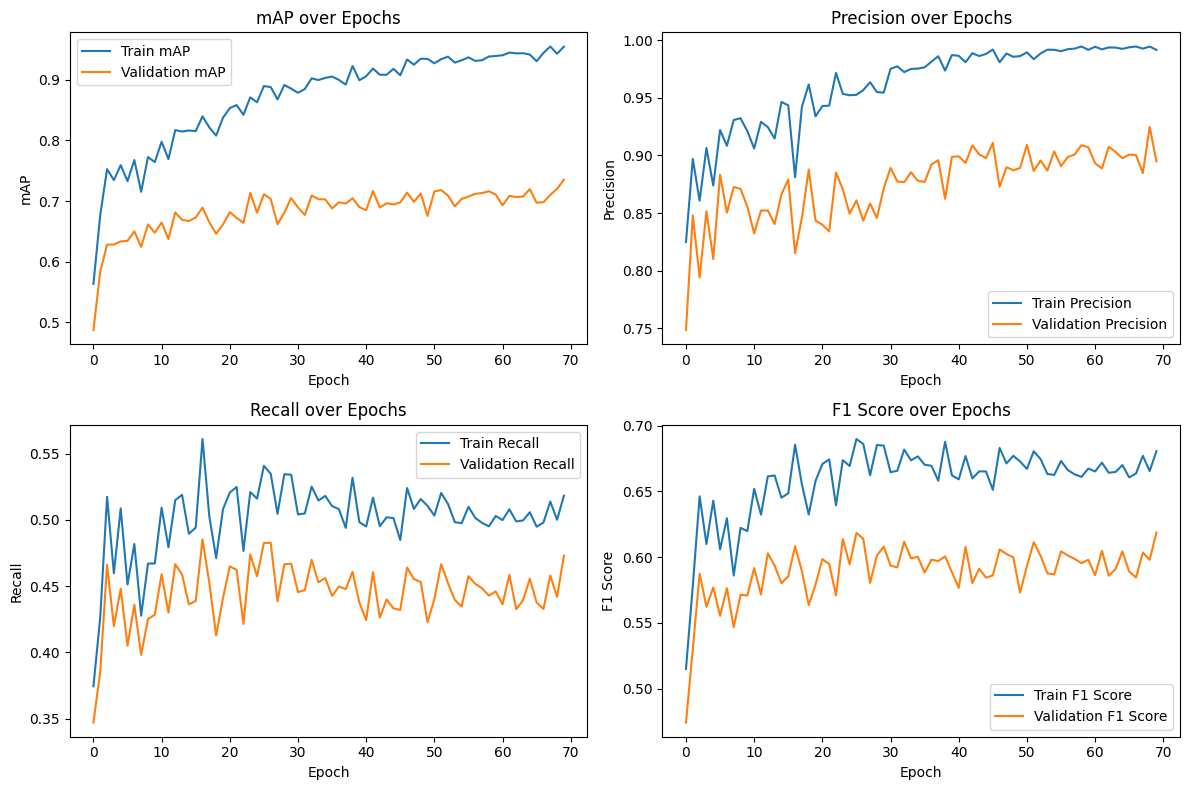

In [ ]:
# import torch
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# from pycocotools.coco import COCO
# import os

# # Define necessary functions
# def iou(box1, box2):
#     """Compute the IoU of two bounding boxes."""
#     x1, y1, x2, y2 = box1
#     x1g, y1g, x2g, y2g = box2

#     xi1, yi1 = max(x1, x1g), max(y1, y1g)
#     xi2, yi2 = min(x2, x2g), min(y2, y2g)
#     inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

#     box1_area = (x2 - x1) * (y2 - y1)
#     box2_area = (x2g - x1g) * (y2g - y1g)
#     union_area = box1_area + box2_area - inter_area

#     return inter_area / union_area if union_area > 0 else 0

# def calculate_precision_recall(all_boxes, all_scores, all_labels, true_boxes, true_labels, iou_threshold=0.5):
#     """Calculate precision and recall for a given IoU threshold."""
#     if len(all_scores) == 0:
#         return np.array([]), np.array([]), np.array([])

#     sorted_indices = np.argsort(-np.array(all_scores))
#     all_boxes = np.array(all_boxes)[sorted_indices]
#     all_labels = np.array(all_labels)[sorted_indices]
#     all_scores = np.array(all_scores)[sorted_indices]

#     num_true_boxes = len(true_boxes)
#     num_pred_boxes = len(all_boxes)

#     true_positive = np.zeros(num_pred_boxes)
#     false_positive = np.zeros(num_pred_boxes)
#     detected_boxes = []

#     for idx, pred_box in enumerate(all_boxes):
#         max_iou = 0
#         max_idx = -1
#         for jdx, true_box in enumerate(true_boxes):
#             if all_labels[idx] == true_labels[jdx] and jdx not in detected_boxes:
#                 current_iou = iou(pred_box, true_box)
#                 if current_iou > max_iou:
#                     max_iou = current_iou
#                     max_idx = jdx

#         if max_iou >= iou_threshold:
#             true_positive[idx] = 1
#             detected_boxes.append(max_idx)
#         else:
#             false_positive[idx] = 1

#     cum_tp = np.cumsum(true_positive)
#     cum_fp = np.cumsum(false_positive)
#     precision = cum_tp / (cum_tp + cum_fp) if (cum_tp + cum_fp).sum() > 0 else np.array([])
#     recall = cum_tp / num_true_boxes if num_true_boxes > 0 else np.array([])

#     return precision, recall, all_scores

# def calculate_ap(precision, recall):
#     """Calculate the average precision for a single class."""
#     if len(precision) == 0 or len(recall) == 0:
#         return 0.0

#     recall = np.concatenate(([0.0], recall, [1.0]))
#     precision = np.concatenate(([0.0], precision, [0.0]))

#     for i in range(len(precision) - 2, -1, -1):
#         precision[i] = max(precision[i], precision[i + 1])

#     indices = np.where(recall[1:] != recall[:-1])[0]
#     average_precision = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])

#     return average_precision

# def evaluate_model(loader, model, device, class_names, iou_thresh=0.5):
#     model.eval()
#     all_detections = []
#     all_annotations = []

#     with torch.no_grad():
#         for images, targets in loader:
#             images = list(img.to(device) for img in images)
#             outputs = model(images)

#             for i, output in enumerate(outputs):
#                 scores = output['scores'].cpu().numpy()
#                 labels = output['labels'].cpu().numpy()
#                 boxes = output['boxes'].cpu().numpy()

#                 target_boxes = targets[i]['boxes'].cpu().numpy()
#                 target_labels = targets[i]['labels'].cpu().numpy()

#                 valid = scores > 0.5
#                 scores = scores[valid]
#                 labels = labels[valid]
#                 boxes = boxes[valid]

#                 all_detections.extend([(box, score, label) for box, score, label in zip(boxes, scores, labels)])
#                 all_annotations.extend([(box, label) for box, label in zip(target_boxes, target_labels)])

#     if not all_detections:
#         return [], [], [], 0

#     pred_boxes, pred_scores, pred_labels = zip(*all_detections)
#     true_boxes, true_labels = zip(*all_annotations)

#     aps, precisions, recalls = [], [], []

#     for class_id in range(1, n_classes):  # Loop through actual class IDs 1 to 5
#         class_pred_boxes = [pred_boxes[i] for i in range(len(pred_labels)) if pred_labels[i] == class_id]
#         class_pred_scores = [pred_scores[i] for i in range(len(pred_labels)) if pred_labels[i] == class_id]
#         class_true_boxes = [true_boxes[i] for i in range(len(true_labels)) if true_labels[i] == class_id]

#         precision, recall, _ = calculate_precision_recall(class_pred_boxes, class_pred_scores, [class_id]*len(class_pred_boxes), class_true_boxes, [class_id]*len(class_true_boxes), iou_threshold=iou_thresh)
#         ap = calculate_ap(precision, recall)

#         if len(precision) == 0:
#             print(f"No predictions for {class_names[class_id-1]}.")
#         if len(recall) == 0:
#             print(f"No true positives for {class_names[class_id-1]}.")

#         aps.append(ap)
#         precisions.append(np.mean(precision) if len(precision) > 0 else float('nan'))
#         recalls.append(np.mean(recall) if len(recall) > 0 else float('nan'))

#     mean_ap = np.mean(aps)
#     return precisions, recalls, aps, mean_ap

# # Usage of the function with the actual number of classes
# n_classes = len(categories.keys())
# classes = [i[1]['name'] for i in categories.items()]

# # Verify GPU availability
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("CUDA is available. Using GPU.")
# else:
#     device = torch.device("cpu")
#     print("CUDA is not available. Using CPU.")

# model = model.to(device)

# num_epochs = 70

# # Initialize lists to store loss values
# epoch_losses = []
# epoch_losses_dict = []

# # Start the timer for total training time
# total_start_time = time.time()

# # Initialize lists to store metrics for each epoch
# train_mAPs, val_mAPs = [], []
# train_precisions, val_precisions = [], []
# train_recalls, val_recalls = [], []

# for epoch in range(num_epochs):
#     # Start the timer for the epoch
#     epoch_start_time = time.time()

#     losses, losses_dict = train_one_epoch(model, optimizer, train_loader, device, epoch)

#     # Evaluate on training set
#     train_precisions_epoch, train_recalls_epoch, train_aps, train_mean_ap = evaluate_model(train_loader, model, device, classes)
#     train_mAPs.append(train_mean_ap)
#     train_precisions.append(np.nanmean(train_precisions_epoch))
#     train_recalls.append(np.nanmean(train_recalls_epoch))
#     print(f"Epoch {epoch} - Train mAP@0.50: {train_mean_ap}")
#     for class_id, (precision, recall, ap) in enumerate(zip(train_precisions_epoch, train_recalls_epoch, train_aps), start=1):
#         print(f"{classes[class_id-1]} - Precision: {precision}, Recall: {recall}, AP: {ap}")

#     # Evaluate on validation set
#     val_precisions_epoch, val_recalls_epoch, val_aps, val_mean_ap = evaluate_model(val_loader, model, device, classes)
#     val_mAPs.append(val_mean_ap)
#     val_precisions.append(np.nanmean(val_precisions_epoch))
#     val_recalls.append(np.nanmean(val_recalls_epoch))
#     print(f"Epoch {epoch} - Validation mAP@0.50: {val_mean_ap}")
#     for class_id, (precision, recall, ap) in enumerate(zip(val_precisions_epoch, val_recalls_epoch, val_aps), start=1):
#         print(f"{classes[class_id-1]} - Precision: {precision}, Recall: {recall}, AP: {ap}")

#     # Store the epoch loss values
#     epoch_losses.append(np.mean(losses))
#     epoch_losses_dict.append(losses_dict.mean())

#     # End the timer for the epoch
#     epoch_end_time = time.time()
#     epoch_duration = epoch_end_time - epoch_start_time
#     print(f"Epoch {epoch} completed in {epoch_duration:.2f} seconds")

# # End the timer for total training time
# total_end_time = time.time()
# total_duration = total_end_time - total_start_time
# print(f"Total training time: {total_duration:.2f} seconds")

# # Plot the stored metrics
# epochs = range(num_epochs)
# plt.figure(figsize=(12, 8))

# # Plot mAP
# plt.subplot(2, 2, 1)
# plt.plot(epochs, train_mAPs, label='Train mAP')
# plt.plot(epochs, val_mAPs, label='Validation mAP')
# plt.xlabel('Epoch')
# plt.ylabel('mAP')
# plt.title('mAP over Epochs')
# plt.legend()

# # Plot Precision
# plt.subplot(2, 2, 2)
# plt.plot(epochs, train_precisions, label='Train Precision')
# plt.plot(epochs, val_precisions, label='Validation Precision')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.title('Precision over Epochs')
# plt.legend()

# # Plot Recall
# plt.subplot(2, 2, 3)
# plt.plot(epochs, train_recalls, label='Train Recall')
# plt.plot(epochs, val_recalls, label='Validation Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.title('Recall over Epochs')
# plt.legend()

# # Plot F1 Score
# train_f1_scores = [2 * (p * r) / (p + r) for p, r in zip(train_precisions, train_recalls)]
# val_f1_scores = [2 * (p * r) / (p + r) for p, r in zip(val_precisions, val_recalls)]
# plt.subplot(2, 2, 4)
# plt.plot(epochs, train_f1_scores, label='Train F1 Score')
# plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.title('F1 Score over Epochs')
# plt.legend()

# plt.tight_layout()
# plt.show()


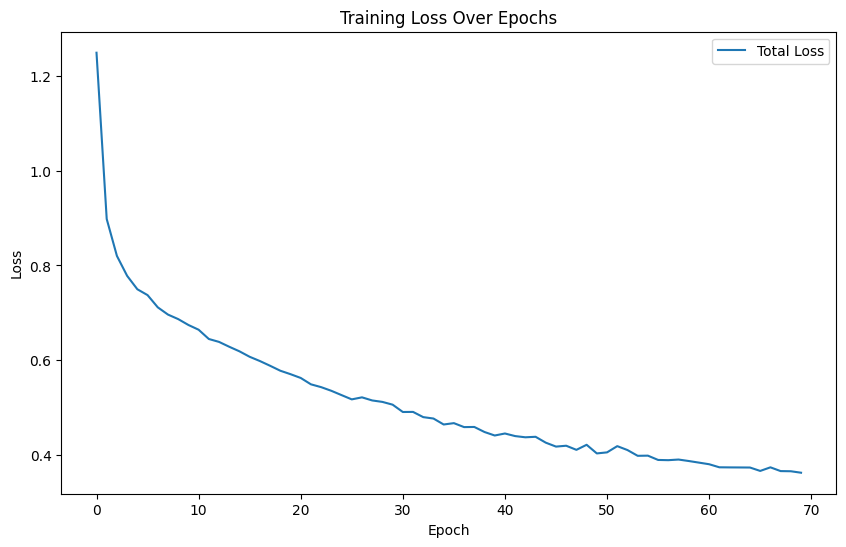

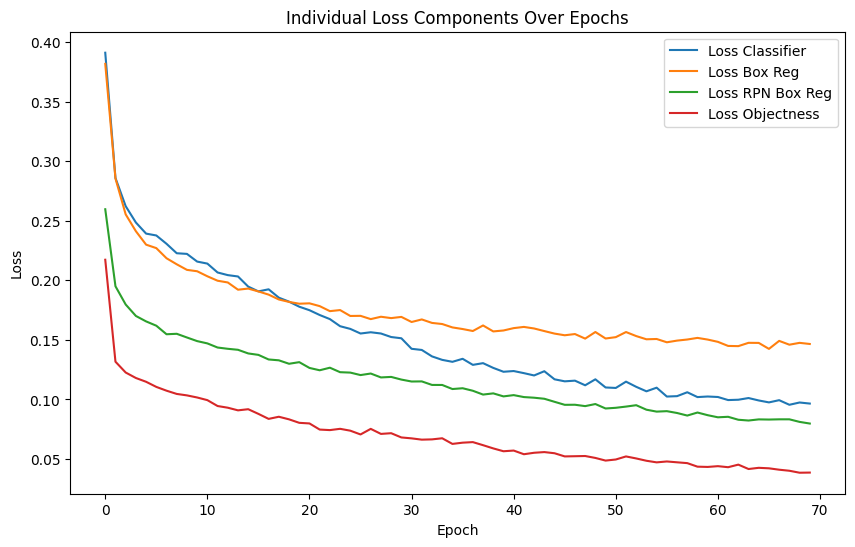

In [ ]:
  # Convert epoch_losses_dict to a DataFrame for easier plotting
epoch_losses_df = pd.DataFrame(epoch_losses_dict)

# Plot the overall loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the individual components of the loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_losses_df['loss_classifier'], label='Loss Classifier')
plt.plot(range(num_epochs), epoch_losses_df['loss_box_reg'], label='Loss Box Reg')
plt.plot(range(num_epochs), epoch_losses_df['loss_rpn_box_reg'], label='Loss RPN Box Reg')
plt.plot(range(num_epochs), epoch_losses_df['loss_objectness'], label='Loss Objectness')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Individual Loss Components Over Epochs')
plt.legend()
plt.show()


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = UI_Element_Detection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
img, _ = test_dataset[45]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

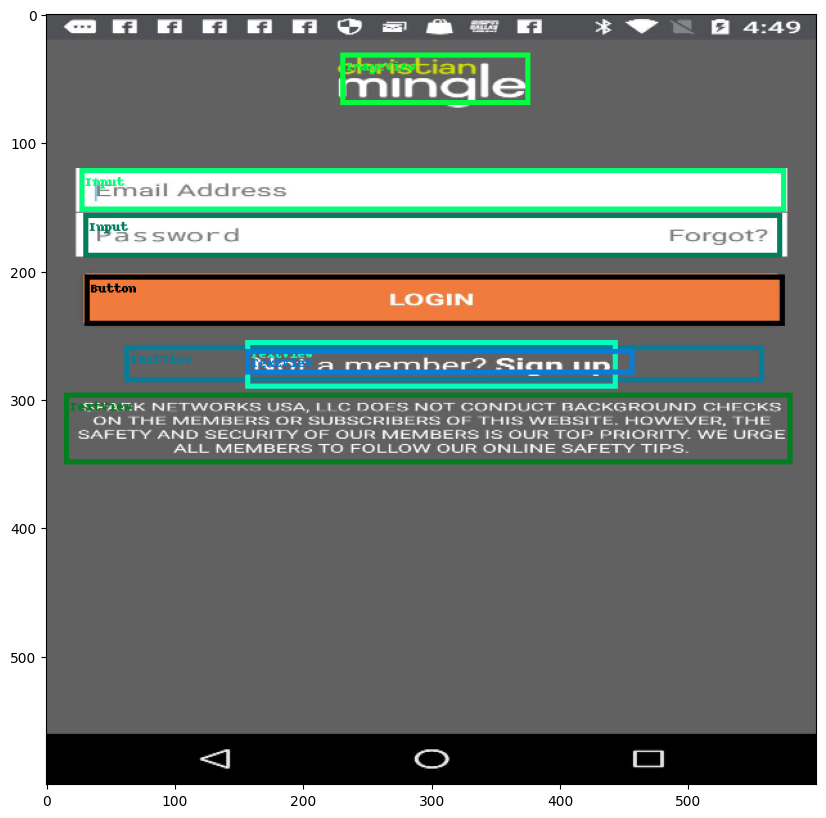

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Detected text: SIGN IN
Detected text: JOIN ENTERPRISE PLUS
Detected text: OR COMPLETE YouR ENROLLMENT
Detected text: Forgot PASSwORD?
Detected text: Emerald Club Members
Detected text: EMAIL MEMBER NUMBER
Detected text: Keep me signed in
Detected text: PASSWORD
Detected text: Forgot MEMBER NUMB


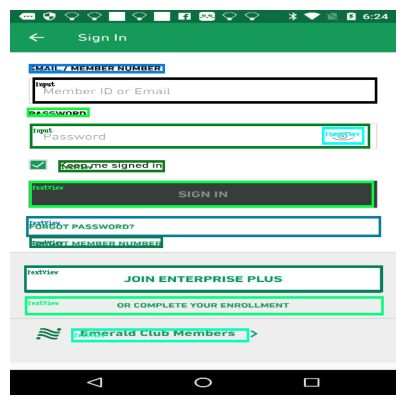

Detected text: Your emall address WIlI be used t0 send you addltlonal information based on your childs assessment View Privac}
Detected text: Password
Detected text: Email Addres
Detected text: Get Started
Detected text: 


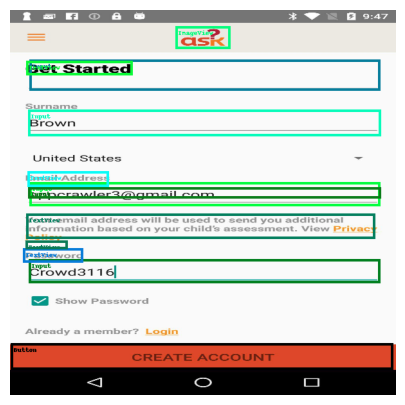

Detected text: 
Detected text: Your Password must consist of 7 t0 50 characters and include ~At least one number At least one uppercase letter At least one lowercase letter No special characters (& $_ etc ) And no morc than 4 consecutive repcating characters
Detected text: 02016 First Data Corporation AII rights reserved
Detected text: Your Password must consist of to 50 characters and include:
Detected text: Privacy Policy | Terms of Use
Detected text: 


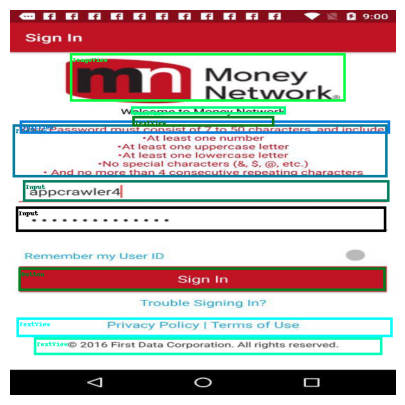

Detected text: 


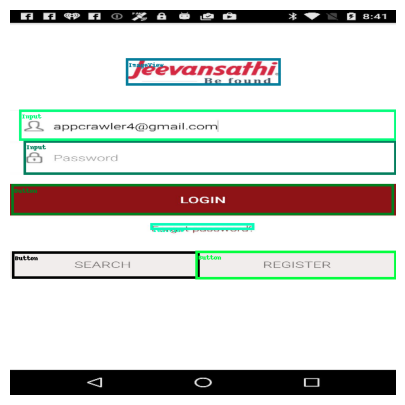

Detected text: Not member? Sign up_
Detected text: Forgot your password?
Detected text: or
Detected text: Already subscribed through Google Play?
Detected text: or


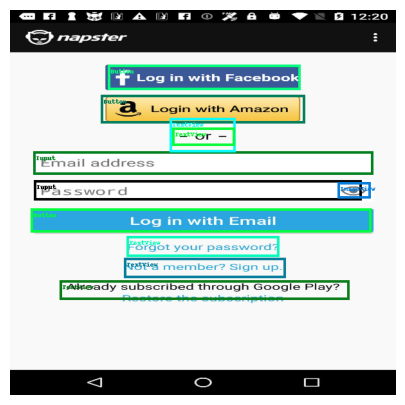

Detected text: Login


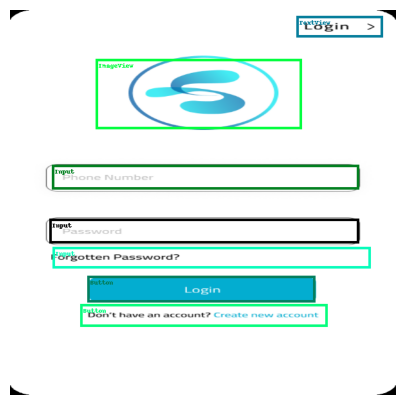

In [ ]:
import pandas as pd
from flask import Flask, request, jsonify

import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import numpy as np
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2
import easyocr
from IPython.display import display, HTML
import ipywidgets as widgets


# Load the expert dataset
expert_dataset_path = '/content/drive/My Drive/MASC_UI_dataset/MASC_UI/MASC_UI/expert_dataset.xlsx'
expert_df = pd.read_excel(expert_dataset_path)
login_texts = expert_df['Login'].dropna().tolist()
home_texts = expert_df['Home'].dropna().tolist()
welcome_texts = expert_df['Welcome'].dropna().tolist()
profile_texts = expert_df['Profile'].dropna().tolist()

reader = easyocr.Reader(['en'])  # Initialize EasyOCR with English language support

# Function to load an image from file picker
def load_image(uploaded):
    image = Image.open(io.BytesIO(uploaded['content'])).convert("RGB")
    return image

# Function to preprocess the image without bbox parameters for inference
def preprocess_image_inference(image, transform):
    image = np.array(image)
    transformed = transform(image=image)
    image_tensor = transformed['image']
    return image_tensor.float() / 255.0  # Convert to float32 and normalize

# Function to recognize text
def recognize_text(image, predictions, classes):
    recognized_texts = []
    boxes = predictions['boxes'][predictions['scores'] > 0.5].cpu().numpy()
    labels = predictions['labels'][predictions['scores'] > 0.5].cpu().numpy()

    for box, label in zip(boxes, labels):
        class_name = classes[label]
        if class_name == 'TextView':
            x_min, y_min, x_max, y_max = map(int, box)
            cropped_image = image[y_min:y_max, x_min:x_max]
            results = reader.readtext(cropped_image)
            text_lines = " ".join([result[1] for result in results])  # Join words into a line of text
            recognized_texts.append((text_lines, box, class_name))
            print("Detected text:", text_lines)  # Print only the text line
    return recognized_texts

# Function to visualize results
def visualize_results(image_tensor, predictions, classes):
    img_np = (image_tensor * 255).to(torch.uint8).cpu().permute(1, 2, 0).numpy()  # Convert to numpy for visualization
    recognized_texts = recognize_text(img_np, predictions, classes)

    fig = plt.figure(figsize=(7, 5))
    plt.imshow(draw_bounding_boxes(
        (image_tensor * 255).to(torch.uint8).cpu(),
        predictions['boxes'][predictions['scores'] > 0.5].cpu(),
        [classes[i] for i in predictions['labels'][predictions['scores'] > 0.5].tolist()],
        width=4).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    return recognized_texts

# Function to check UX and get suggestions
def check_ux_and_suggestions(detected_texts, labels):
    detected_words = set(" ".join([text for text, _, _ in detected_texts]).split())

    # Combine all expert dataset texts into a single set of words
    expert_words = set()
    for column_texts in [login_texts, home_texts, welcome_texts, profile_texts]:
        for text in column_texts:
            expert_words.update(text.split())

    # Check if any detected word matches any expert word
    if detected_words & expert_words:
        return "Good UX", None

    detected_labels = set(labels)

    # Check for Login screen
    if 'Input' in detected_labels and not any(word in detected_words for word in login_texts):
        return "Fault in UX - Login", login_texts

    # Check for Home screen
    if detected_labels == {'ImageView', 'TextView', 'Button'}:
        return "Fault in UX - Home", home_texts

    # Check for Welcome screen
    if detected_labels <= {'ImageView', 'Button'} and len(detected_labels) == 2:
        return "Fault in UX - Welcome", welcome_texts

    # Check for Profile screen
    if not any(word in detected_words for word in profile_texts):
        return "Fault in UX - Home", home_texts

    # If none of the above, return Good UX
    return "Good UX", None

# Function to load and predict
def load_and_predict(change):
    uploaded = list(file_picker.value.values())[0]
    if not uploaded:
        return

    new_image = load_image(uploaded)
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ])
    image_tensor = preprocess_image_inference(new_image, transform)

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model([image_tensor])
        pred = predictions[0]

    recognized_texts = visualize_results(image_tensor, pred, classes)
    detected_labels = [classes[label] for label in pred['labels'][pred['scores'] > 0.5].cpu().numpy()]
    ux_result, suggestions = check_ux_and_suggestions(recognized_texts, detected_labels)
    if ux_result != "Good UX" and suggestions:
        result_html.value = f"{ux_result}<br><br>Suggestions:<br>" + "<br>".join(suggestions)
    else:
        result_html.value = ux_result

# Create widgets
file_picker = widgets.FileUpload(accept='image/*', multiple=False, description="Upload Image", button_style='info')
file_picker.observe(load_and_predict, names='value')

result_html = widgets.HTML(value="", layout=widgets.Layout(width='100%', height='200px', border='solid 1px black', padding='10px'))

# Display widgets with layout
image_output = widgets.Output(layout=widgets.Layout(width='50%'))
result_output = widgets.VBox([
    widgets.HTML("<h2>UI Element Detection</h2>"),
    file_picker,
    widgets.HTML("<h3>UX Evaluation Result:</h3>"),
    result_html
], layout=widgets.Layout(align_items='center', width='50%', margin='0 auto'))

# Function to load and predict, and update the image_output widget
def load_and_predict(change):
    uploaded = list(file_picker.value.values())[0]
    if not uploaded:
        return

    new_image = load_image(uploaded)
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ])
    image_tensor = preprocess_image_inference(new_image, transform)

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model([image_tensor])
        pred = predictions[0]

    with image_output:
        image_output.clear_output()
        recognized_texts = visualize_results(image_tensor, pred, classes)

    detected_labels = [classes[label] for label in pred['labels'][pred['scores'] > 0.5].cpu().numpy()]
    ux_result, suggestions = check_ux_and_suggestions(recognized_texts, detected_labels)
    if ux_result != "Good UX" and suggestions:
        result_html.value = f"{ux_result}<br><br>Suggestions:<br>" + "<br>".join(suggestions)
    else:
        result_html.value = ux_result

# Display widgets with layout
file_picker.observe(load_and_predict, names='value')

app_layout = widgets.HBox([
    image_output,
    result_output
], layout=widgets.Layout(align_items='center', width='100%', margin='10 auto'))

display(app_layout)
